### Imports

In [674]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

#imports for modelling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

random_state = 42
np.random.seed(42)

## Additional Preprocessing for Multiclass

In [675]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_train.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,glucose_test_performed,a1c_test_performed,insulin,metformin,glimepiride,pioglitazone,rosiglitazone,glipizide,glyburide,repaglinide
0,533253,70110,Caucasian,1,75,NaN,No provider,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,426224,29775006,AfricanAmerican,0,55,NaN,No provider,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,634063,80729253,Caucasian,1,65,NaN,No provider,0,0,1,...,0,0,1,0,1,0,0,0,0,0
3,890610,2919042,AfricanAmerican,0,65,NaN,MC,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,654194,84871971,Caucasian,1,75,NaN,HM,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [676]:
#encoding for multiclass variable
mapping = {'No': 0, '>30 days': 1, '<30 days': 2}
df_train['readmitted_multiclass'] = df_train['readmitted_multiclass'].map(mapping)

### Admission_Source

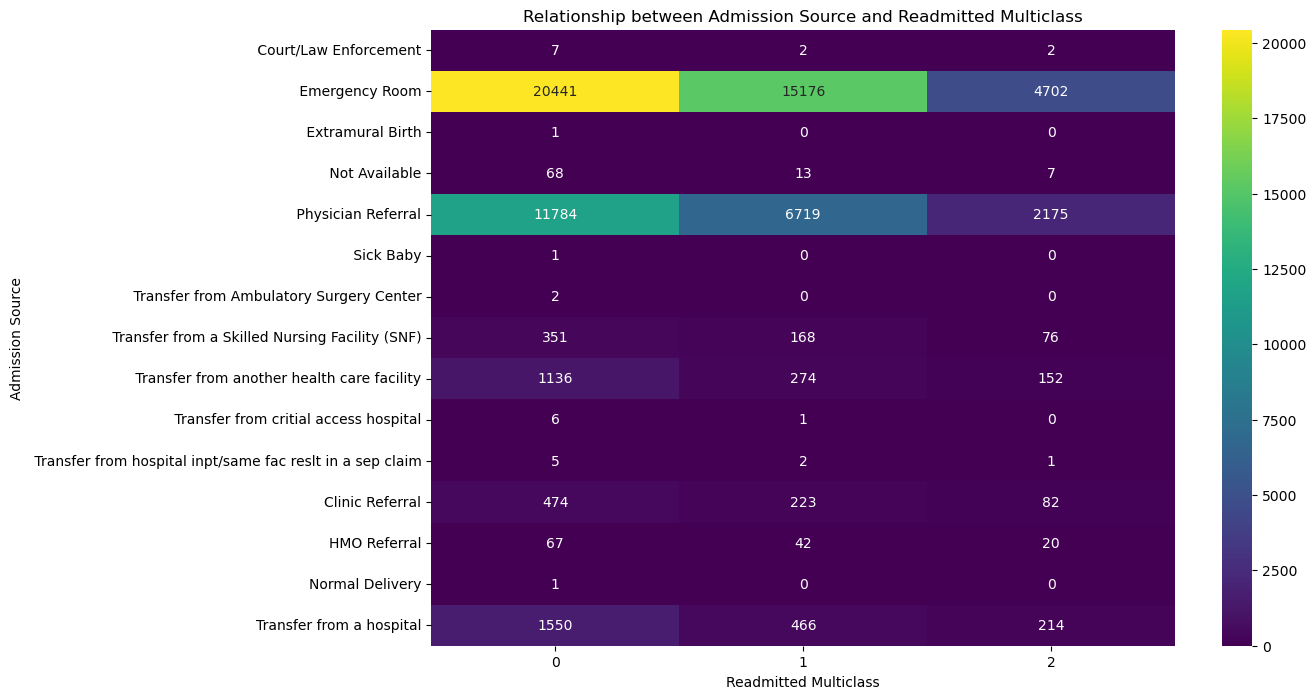

In [677]:
# Create the contingency table
crosstab_result = pd.crosstab(df_train['admission_source'], df_train['readmitted_multiclass'])

# Plot the bar plot
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Relationship between Admission Source and Readmitted Multiclass')
plt.xlabel('Readmitted Multiclass')
plt.ylabel('Admission Source')
plt.show()

In [678]:
df_train['admission_source'] = df_train['admission_source'].fillna("Unknown")

In [679]:
#Calculate the overall proportion for each class in 'readmitted_multiclass'
overall_proportion = df_train['readmitted_multiclass'].value_counts(normalize=True)
overall_proportion

0    0.539123
1    0.349276
2    0.111601
Name: readmitted_multiclass, dtype: float64

In [680]:
#Calculate the proportion of each class within each 'admission_source' and create columns
counts_per_admission_source = df_train.groupby(['admission_source', 'readmitted_multiclass']).size()
total_counts_per_admission_source = df_train['admission_source'].value_counts()
admission_source_proportion = counts_per_admission_source.div(total_counts_per_admission_source, level='admission_source').unstack(fill_value=0)

admission_source_proportion_reset = admission_source_proportion.reset_index()
df_train = df_train.merge(admission_source_proportion_reset, on='admission_source', how='left')

df_train.rename(columns={0: 'admission_source_0', 1:'admission_source_1', 2:'admission_source_2'}, inplace=True)
df_train

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,metformin,glimepiride,pioglitazone,rosiglitazone,glipizide,glyburide,repaglinide,admission_source_0,admission_source_1,admission_source_2
0,533253,70110,Caucasian,1,75,NaN,No provider,0,0,2,...,0,0,0,0,0,0,0,0.506982,0.376398,0.116620
1,426224,29775006,AfricanAmerican,0,55,NaN,No provider,0,0,0,...,0,0,0,0,0,0,0,0.608472,0.286264,0.105263
2,634063,80729253,Caucasian,1,65,NaN,No provider,0,0,1,...,0,1,0,0,0,0,0,0.520415,0.372021,0.107565
3,890610,2919042,AfricanAmerican,0,65,NaN,MC,0,0,1,...,0,0,0,0,0,0,0,0.727273,0.175416,0.097311
4,654194,84871971,Caucasian,1,75,NaN,HM,1,0,0,...,0,0,0,0,0,0,0,0.569881,0.324935,0.105184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71231,660160,24531381,AfricanAmerican,1,85,NaN,MC,0,1,0,...,1,0,0,0,0,1,0,0.569881,0.324935,0.105184
71232,826429,4663818,AfricanAmerican,1,75,NaN,No provider,0,0,0,...,1,0,0,0,0,1,0,0.569881,0.324935,0.105184
71233,332030,23397147,Caucasian,1,65,NaN,No provider,0,2,2,...,0,0,0,0,0,1,0,0.520415,0.372021,0.107565
71234,757560,52161750,Caucasian,0,65,NaN,BC,0,0,2,...,0,0,0,0,0,1,0,0.506982,0.376398,0.116620


In [681]:
#create bins comparing the average of readmitted multiclass and the average of each class in admission source
df_train['admission_source_0_high'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['admission_source_0_low'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['admission_source_1_high'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['admission_source_1_low'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['admission_source_2_high'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['admission_source_2_low'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)

#### Medical_specialty

In [682]:
# Replacing missing values in 'medical_specialty' with a placeholder 'Unknown'
df_train['medical_specialty'].fillna('Unknown', inplace=True)

In [683]:
# Calculate the proportion of each class within each 'medical_specialty' and create columns
counts_per_medical_specialty = df_train.groupby(['medical_specialty', 'readmitted_multiclass']).size()
total_counts_per_medical_specialty = df_train['medical_specialty'].value_counts()
medical_specialty_proportion = counts_per_medical_specialty.div(total_counts_per_medical_specialty, level='medical_specialty').unstack(fill_value=0)

# Reset the index
medical_specialty_proportion_reset = medical_specialty_proportion.reset_index()
df_train = df_train.merge(medical_specialty_proportion_reset, on='medical_specialty', how='left')

# Rename columns
df_train.rename(columns={0: 'medical_specialty_0', 1: 'medical_specialty_1', 2: 'medical_specialty_2'}, inplace=True)

In [684]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in medical specialty
df_train['medical_specialty_0_high'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['medical_specialty_0_low'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['medical_specialty_1_high'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['medical_specialty_1_low'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['medical_specialty_2_high'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['medical_specialty_2_low'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)


#### Discharge_disposition

In [685]:
df_train['discharge_disposition'] = df_train['discharge_disposition'].fillna("Unknown")

In [686]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_discharge_disposition = df_train.groupby(['discharge_disposition', 'readmitted_multiclass']).size()
total_counts_per_discharge_disposition = df_train['discharge_disposition'].value_counts()

discharge_disposition_proportion = counts_per_discharge_disposition.div(total_counts_per_discharge_disposition, level='discharge_disposition').unstack(fill_value=0)
discharge_disposition_proportion_reset = discharge_disposition_proportion.reset_index()

df_train = df_train.merge(discharge_disposition_proportion_reset, on='discharge_disposition', how='left')

df_train.rename(columns={0: 'discharge_disposition_0', 1: 'discharge_disposition_1', 2: 'discharge_disposition_2'}, inplace=True)

In [687]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in discharge disposition
df_train['discharge_disposition_0_high'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['discharge_disposition_0_low'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['discharge_disposition_1_high'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['discharge_disposition_1_low'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['discharge_disposition_2_high'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['discharge_disposition_2_low'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)

### Diagnosis variables 

Primary Diagnosis

In [688]:
# Same logic as before, calculate the proportion of each class within each 'primary diagnosis' and create columns accordingly
counts_per_primary_diagnosis = df_train.groupby(['primary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_primary_diagnosis = df_train['primary_diagnosis'].value_counts()

primary_diagnosis_proportion = counts_per_primary_diagnosis.div(total_counts_per_primary_diagnosis, level='primary_diagnosis').unstack(fill_value=0)
primary_diagnosis_proportion_reset = primary_diagnosis_proportion.reset_index()

df_train = df_train.merge(primary_diagnosis_proportion_reset, on='primary_diagnosis', how='left')

df_train.rename(columns={0: 'primary_diagnosis_0', 1: 'primary_diagnosis_1', 2: 'primary_diagnosis_2'}, inplace=True)

In [689]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['primary_diagnosis_0_high'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['primary_diagnosis_0_low'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['primary_diagnosis_1_high'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['primary_diagnosis_1_low'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['primary_diagnosis_2_high'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['primary_diagnosis_2_low'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)

Secondary Diagnosis

In [690]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_secondary_diagnosis = df_train.groupby(['secondary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_secondary_diagnosis = df_train['secondary_diagnosis'].value_counts()

secondary_diagnosis_proportion = counts_per_secondary_diagnosis.div(total_counts_per_secondary_diagnosis, level='secondary_diagnosis').unstack(fill_value=0)
secondary_diagnosis_proportion_reset = secondary_diagnosis_proportion.reset_index()

df_train = df_train.merge(secondary_diagnosis_proportion_reset, on='secondary_diagnosis', how='left')

df_train.rename(columns={0: 'secondary_diagnosis_0', 1: 'secondary_diagnosis_1', 2: 'secondary_diagnosis_2'}, inplace=True)

In [691]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['secondary_diagnosis_0_high'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['secondary_diagnosis_0_low'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['secondary_diagnosis_1_high'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['secondary_diagnosis_1_low'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['secondary_diagnosis_2_high'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['secondary_diagnosis_2_low'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)


Additional Diagnosis

In [692]:
# Same logic as before, calculate the proportion of each class within each 'additional_diagnosis' and create columns accordingly
counts_per_additional_diagnosis = df_train.groupby(['additional_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_additional_diagnosis = df_train['additional_diagnosis'].value_counts()

additional_diagnosis_proportion = counts_per_additional_diagnosis.div(total_counts_per_additional_diagnosis, level='additional_diagnosis').unstack(fill_value=0)
additional_diagnosis_proportion_reset = additional_diagnosis_proportion.reset_index()

df_train = df_train.merge(additional_diagnosis_proportion_reset, on='additional_diagnosis', how='left')

df_train.rename(columns={0: 'additional_diagnosis_0', 1: 'additional_diagnosis_1', 2: 'additional_diagnosis_2'}, inplace=True)

In [693]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['additional_diagnosis_0_high'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.65
                                                                            else 0)

df_train['additional_diagnosis_0_low'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.4
                                                                            else 0)

df_train['additional_diagnosis_1_high'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.45
                                                                            else 0)

df_train['additional_diagnosis_1_low'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.25
                                                                            else 0)

df_train['additional_diagnosis_2_high'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.15
                                                                            else 0)

df_train['additional_diagnosis_2_low'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.05
                                                                            else 0)

### Imputation of missing values

In [694]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

features_for_transform = [
    'gender', 
    'has_weight',
    'race_Asian', 'race_Caucasian', 'race_Hispanic',
    'race_Other', 'race_nan',
    
    'age', 
    'average_pulse_bpm',
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'total_visits',
    'max_visits_of_one_type',
    'length_of_stay_in_hospital',
    'number_lab_tests', 
    'non_lab_procedures', 
    'number_of_medications',
    'number_diagnoses'
]

df_train_for_transform = df_train[features_for_transform]

features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

scaler = MinMaxScaler()
scaled_df_train_for_transform = scaler.fit_transform(df_train_for_transform[features_for_scaling])
scaled_df_train_for_transform = np.concatenate((df_train_for_transform[df_train_for_transform.columns.difference(features_for_scaling)],
                np.array(scaled_df_train_for_transform)), axis=1)


imputer = KNNImputer(n_neighbors=5)
imputed_data_train = pd.DataFrame(imputer.fit_transform(scaled_df_train_for_transform), columns = features_for_transform)

imputed_data_train = pd.DataFrame(np.concatenate((imputed_data_train[imputed_data_train.columns.difference(features_for_scaling)],
                scaler.inverse_transform(imputed_data_train[features_for_scaling])), axis = 1), columns = features_for_transform)



features_to_impute = ['age', 'gender', 'number_lab_tests', 'number_of_medications']
df_train[features_to_impute] = np.round(imputed_data_train[features_to_impute])

df_train

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis_2_low,additional_diagnosis_0,additional_diagnosis_1,additional_diagnosis_2,additional_diagnosis_0_high,additional_diagnosis_0_low,additional_diagnosis_1_high,additional_diagnosis_1_low,additional_diagnosis_2_high,additional_diagnosis_2_low
0,533253,70110,Caucasian,1.0,75.0,NaN,No provider,0,0,2,...,0,0.449438,0.471910,0.078652,0,0,1,0,0,0
1,426224,29775006,AfricanAmerican,0.0,55.0,NaN,No provider,0,0,0,...,0,0.536000,0.272000,0.192000,0,0,0,0,1,0
2,634063,80729253,Caucasian,1.0,65.0,NaN,No provider,0,0,1,...,0,0.606072,0.307807,0.086121,0,0,0,0,0,0
3,890610,2919042,AfricanAmerican,0.0,65.0,NaN,MC,0,0,1,...,0,0.560000,0.380000,0.060000,0,0,0,0,0,0
4,654194,84871971,Caucasian,1.0,75.0,NaN,HM,1,0,0,...,0,0.468210,0.406790,0.125000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71231,660160,24531381,AfricanAmerican,1.0,85.0,NaN,MC,0,1,0,...,0,0.606072,0.307807,0.086121,0,0,0,0,0,0
71232,826429,4663818,AfricanAmerican,1.0,75.0,NaN,No provider,0,0,0,...,0,0.666667,0.250000,0.083333,1,0,0,0,0,0
71233,332030,23397147,Caucasian,1.0,65.0,NaN,No provider,0,2,2,...,0,0.533759,0.348708,0.117533,0,0,0,0,0,0
71234,757560,52161750,Caucasian,0.0,65.0,NaN,BC,0,0,2,...,0,0.424528,0.410377,0.165094,0,0,0,0,1,0


In [695]:
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       ...
       'secondary_diagnosis_2_low', 'additional_diagnosis_0',
       'additional_diagnosis_1', 'additional_diagnosis_2',
       'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
       'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
       'additional_diagnosis_2_high', 'additional_diagnosis_2_low'],
      dtype='object', length=157)

## Model and feature selection

### Set train and test data

In [698]:
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 

                  'medical_specialty_0_high', 'medical_specialty_0_low', 'medical_specialty_1_high', 
                  'medical_specialty_1_low', 'medical_specialty_2_high', 'medical_specialty_2_low',

                  'admission_source_0_high',	'admission_source_0_low',	'admission_source_1_high',	'admission_source_1_low',
                  'admission_source_2_high',	'admission_source_2_low',

                  'discharge_disposition_0_high', 'discharge_disposition_0_low',
                  'discharge_disposition_1_high', 'discharge_disposition_1_low',
                  'discharge_disposition_2_high', 'discharge_disposition_2_low',
                  
                  'primary_diagnosis_2_low', 'primary_diagnosis_2_high','primary_diagnosis_1_low',
                  'primary_diagnosis_1_high','primary_diagnosis_0_low','primary_diagnosis_0_high',

                  'secondary_diagnosis_2_low', 'secondary_diagnosis_2_high','secondary_diagnosis_1_low',
                  'secondary_diagnosis_1_high','secondary_diagnosis_0_low','secondary_diagnosis_0_high',                   
                   
                  'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
                  'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
                  'additional_diagnosis_2_high', 'additional_diagnosis_2_low',
                                
                  'number_lab_tests',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_performed', 
        
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_No provider',
                  'payer_code_Other provider',        
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 

In [699]:
data = df_train[columns_to_use]
target = df_train['readmitted_multiclass']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### Imports for modelling

In [700]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
                        pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [701]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [702]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [703]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [704]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass = True,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in range(cv):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]


        #Target encoding
        if target_encoding == True:
                val_data, _ = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

            
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]

        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'micro'), f1_score(y_val, y_pred_val, average = 'micro')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'micro'), recall_score(y_val, y_pred_val, average = 'micro')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'micro'), precision_score(y_val, y_pred_val, average = 'micro')])
            # roc_auc_score_list.append([roc_auc_score( y_train, y_pred_train.reshape(-1, 1), multi_class='ovr', average = 'micro'), roc_auc_score(y_val, y_pred_val.reshape(-1, 1), multi_class='ovr', average = 'micro')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.mean(np.array(feature_imp), axis = 0),
            ]

### Important functions

### Model selection

In [705]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications', 'admission_type_freq']

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'

**Random Forest**

In [706]:
model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.random.randint(100, 200, 10),
    'max_depth': np.random.randint(10, 20, 10),
    'min_samples_split': np.random.randint(2, 10, 10),
    'min_samples_leaf': np.random.randint(5, 20, 10),
    # 'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None],
    # 'max_leaf_nodes': [None, 10, 20]
}

result = []
for i in range(20):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model,
                     random_params,  
                     multiclass = True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = False, 
                     upsample_size = 1,
                     cv=5))

KeyError: '[4, 6, 32, 35, 39, 52, 70, 80, 83, 88, 101, 110, 114, 124, 127, 130, 137, 144, 158, 161, 170, 176, 182, 195, 197, 198, 212, 216, 221, 222, 224, 225, 237, 253, 261, 262, 267, 269, 273, 274, 280, 285, 295, 313, 341, 342, 344, 353, 356, 359, 369, 373, 378, 379, 380, 383, 396, 399, 402, 410, 416, 417, 428, 429, 430, 431, 433, 441, 444, 446, 452, 454, 457, 481, 482, 484, 501, 504, 505, 512, 522, 532, 539, 542, 543, 549, 564, 578, 581, 585, 588, 593, 604, 611, 612, 614, 616, 624, 628, 629, 630, 644, 646, 651, 655, 673, 681, 689, 696, 701, 708, 712, 720, 729, 736, 738, 745, 754, 756, 759, 771, 773, 776, 800, 803, 829, 836, 839, 848, 851, 853, 862, 866, 871, 873, 884, 890, 896, 902, 914, 926, 935, 936, 942, 943, 953, 955, 962, 963, 965, 966, 967, 971, 980, 985, 986, 994, 998, 1000, 1001, 1003, 1005, 1013, 1021, 1032, 1033, 1035, 1038, 1043, 1045, 1048, 1057, 1059, 1061, 1068, 1072, 1087, 1090, 1092, 1097, 1114, 1118, 1121, 1126, 1131, 1141, 1164, 1165, 1167, 1170, 1171, 1173, 1174, 1180, 1181, 1200, 1213, 1220, 1221, 1230, 1246, 1253, 1270, 1275, 1276, 1278, 1285, 1289, 1290, 1291, 1295, 1296, 1298, 1309, 1314, 1317, 1319, 1322, 1330, 1334, 1346, 1348, 1349, 1351, 1380, 1385, 1397, 1410, 1413, 1414, 1418, 1419, 1422, 1433, 1441, 1443, 1449, 1463, 1465, 1477, 1483, 1491, 1498, 1503, 1507, 1512, 1518, 1519, 1520, 1523, 1529, 1534, 1536, 1551, 1554, 1566, 1570, 1574, 1575, 1576, 1580, 1583, 1590, 1592, 1598, 1599, 1603, 1618, 1621, 1633, 1640, 1641, 1644, 1655, 1670, 1671, 1675, 1679, 1685, 1689, 1696, 1710, 1718, 1731, 1734, 1736, 1738, 1741, 1744, 1747, 1748, 1761, 1762, 1784, 1786, 1795, 1798, 1805, 1812, 1815, 1818, 1824, 1830, 1836, 1856, 1859, 1866, 1870, 1879, 1880, 1888, 1897, 1916, 1923, 1928, 1931, 1941, 1945, 1960, 1966, 1970, 1978, 1990, 2009, 2032, 2055, 2060, 2061, 2065, 2072, 2077, 2089, 2097, 2098, 2113, 2125, 2126, 2135, 2138, 2145, 2152, 2161, 2165, 2180, 2181, 2193, 2195, 2210, 2218, 2225, 2229, 2233, 2235, 2247, 2254, 2255, 2265, 2273, 2284, 2287, 2290, 2295, 2296, 2298, 2299, 2305, 2307, 2309, 2313, 2320, 2322, 2324, 2328, 2330, 2331, 2349, 2350, 2359, 2360, 2362, 2372, 2373, 2375, 2383, 2386, 2391, 2399, 2432, 2436, 2441, 2449, 2463, 2476, 2480, 2493, 2494, 2499, 2508, 2515, 2518, 2522, 2527, 2528, 2530, 2541, 2549, 2556, 2558, 2578, 2579, 2592, 2605, 2608, 2616, 2618, 2623, 2625, 2626, 2630, 2638, 2641, 2644, 2652, 2662, 2679, 2680, 2683, 2688, 2691, 2707, 2721, 2726, 2727, 2730, 2731, 2746, 2750, 2758, 2761, 2762, 2771, 2776, 2777, 2780, 2784, 2791, 2793, 2796, 2797, 2805, 2807, 2813, 2815, 2851, 2854, 2863, 2865, 2867, 2868, 2875, 2880, 2885, 2891, 2893, 2898, 2905, 2907, 2909, 2915, 2916, 2927, 2935, 2937, 2941, 2949, 2954, 2955, 2968, 2969, 2971, 2975, 2980, 2982, 2984, 2990, 3002, 3003, 3010, 3011, 3026, 3027, 3028, 3031, 3037, 3050, 3053, 3056, 3057, 3073, 3077, 3083, 3099, 3108, 3116, 3118, 3120, 3124, 3132, 3137, 3153, 3156, 3171, 3173, 3179, 3184, 3189, 3200, 3208, 3214, 3220, 3229, 3242, 3263, 3265, 3270, 3272, 3278, 3284, 3292, 3298, 3304, 3308, 3310, 3335, 3342, 3348, 3354, 3375, 3382, 3388, 3396, 3401, 3416, 3418, 3419, 3425, 3428, 3431, 3432, 3433, 3437, 3441, 3452, 3461, 3473, 3482, 3495, 3502, 3507, 3510, 3511, 3524, 3555, 3564, 3565, 3575, 3585, 3593, 3601, 3609, 3613, 3615, 3617, 3635, 3645, 3647, 3661, 3697, 3698, 3700, 3702, 3707, 3711, 3714, 3715, 3725, 3732, 3735, 3737, 3738, 3767, 3776, 3777, 3787, 3788, 3789, 3795, 3799, 3802, 3804, 3805, 3821, 3826, 3829, 3840, 3850, 3854, 3859, 3861, 3862, 3863, 3867, 3872, 3874, 3885, 3886, 3899, 3906, 3908, 3913, 3914, 3927, 3928, 3930, 3933, 3935, 3940, 3944, 3946, 3955, 3978, 3989, 3994, 3997, 4004, 4012, 4021, 4028, 4034, 4036, 4039, 4044, 4057, 4060, 4066, 4086, 4088, 4091, 4095, 4097, 4103, 4105, 4107, 4108, 4128, 4129, 4139, 4143, 4144, 4145, 4148, 4155, 4157, 4162, 4168, 4183, 4203, 4207, 4208, 4229, 4232, 4244, 4245, 4246, 4248, 4249, 4251, 4252, 4256, 4264, 4269, 4282, 4287, 4289, 4293, 4304, 4309, 4313, 4328, 4336, 4337, 4346, 4348, 4364, 4374, 4380, 4384, 4385, 4387, 4391, 4399, 4402, 4404, 4411, 4416, 4420, 4421, 4422, 4431, 4442, 4446, 4448, 4449, 4452, 4456, 4464, 4469, 4492, 4503, 4510, 4519, 4528, 4530, 4543, 4557, 4563, 4568, 4577, 4580, 4584, 4586, 4605, 4609, 4613, 4614, 4615, 4623, 4625, 4631, 4635, 4639, 4644, 4645, 4657, 4669, 4672, 4673, 4679, 4699, 4719, 4724, 4735, 4740, 4745, 4751, 4766, 4775, 4780, 4786, 4790, 4801, 4810, 4815, 4818, 4829, 4845, 4859, 4871, 4878, 4879, 4882, 4883, 4884, 4885, 4890, 4891, 4894, 4896, 4900, 4911, 4916, 4918, 4927, 4940, 4948, 4972, 4977, 4981, 4989, 4990, 4997, 4998, 5005, 5011, 5012, 5013, 5014, 5026, 5034, 5047, 5055, 5058, 5068, 5071, 5073, 5086, 5089, 5090, 5093, 5106, 5115, 5118, 5124, 5130, 5134, 5137, 5146, 5157, 5162, 5169, 5170, 5173, 5182, 5185, 5194, 5205, 5211, 5216, 5223, 5227, 5228, 5231, 5246, 5252, 5253, 5265, 5266, 5268, 5276, 5288, 5299, 5300, 5323, 5324, 5325, 5326, 5330, 5333, 5342, 5343, 5345, 5346, 5359, 5360, 5382, 5394, 5396, 5398, 5414, 5421, 5428, 5438, 5444, 5449, 5453, 5464, 5466, 5473, 5476, 5479, 5485, 5496, 5512, 5517, 5522, 5528, 5532, 5537, 5540, 5547, 5549, 5552, 5562, 5563, 5564, 5572, 5576, 5579, 5598, 5601, 5604, 5619, 5621, 5625, 5633, 5662, 5667, 5669, 5671, 5672, 5677, 5706, 5711, 5712, 5715, 5716, 5718, 5732, 5735, 5740, 5748, 5757, 5761, 5763, 5766, 5770, 5771, 5775, 5777, 5779, 5784, 5788, 5795, 5799, 5803, 5808, 5819, 5827, 5828, 5835, 5841, 5843, 5847, 5854, 5855, 5859, 5860, 5865, 5874, 5875, 5879, 5880, 5890, 5897, 5907, 5918, 5923, 5924, 5927, 5945, 5946, 5952, 5953, 5954, 5955, 5970, 5975, 5982, 5986, 5989, 5992, 5994, 6010, 6013, 6016, 6019, 6020, 6034, 6036, 6048, 6049, 6052, 6059, 6061, 6065, 6075, 6079, 6095, 6100, 6108, 6128, 6132, 6133, 6136, 6144, 6145, 6148, 6151, 6153, 6165, 6175, 6179, 6183, 6184, 6188, 6194, 6196, 6201, 6204, 6205, 6211, 6225, 6231, 6232, 6234, 6235, 6247, 6257, 6272, 6280, 6288, 6289, 6293, 6297, 6310, 6322, 6328, 6330, 6334, 6347, 6348, 6350, 6366, 6370, 6383, 6388, 6390, 6392, 6399, 6409, 6418, 6423, 6424, 6425, 6429, 6430, 6432, 6435, 6451, 6465, 6467, 6468, 6478, 6479, 6481, 6484, 6491, 6497, 6498, 6501, 6502, 6510, 6515, 6519, 6526, 6527, 6529, 6541, 6545, 6555, 6558, 6561, 6568, 6573, 6578, 6585, 6592, 6597, 6623, 6627, 6633, 6636, 6648, 6650, 6651, 6665, 6666, 6672, 6675, 6676, 6682, 6685, 6689, 6698, 6701, 6702, 6717, 6724, 6731, 6736, 6742, 6748, 6752, 6754, 6757, 6758, 6759, 6779, 6793, 6802, 6804, 6819, 6821, 6830, 6839, 6851, 6860, 6873, 6875, 6896, 6913, 6916, 6919, 6921, 6924, 6926, 6930, 6935, 6936, 6939, 6942, 6943, 6945, 6946, 6948, 6964, 6975, 6976, 6978, 6987, 6990, 6991, 6994, 6995, 7002, 7007, 7010, 7022, 7024, 7026, 7027, 7029, 7040, 7055, 7059, 7060, 7064, 7072, 7100, 7106, 7110, 7117, 7119, 7128, 7133, 7134, 7143, 7144, 7149, 7158, 7167, 7168, 7173, 7177, 7180, 7182, 7200, 7201, 7205, 7209, 7217, 7220, 7225, 7255, 7258, 7266, 7270, 7277, 7278, 7281, 7285, 7290, 7291, 7299, 7315, 7318, 7324, 7325, 7327, 7329, 7339, 7340, 7359, 7360, 7363, 7366, 7379, 7390, 7395, 7401, 7409, 7411, 7412, 7416, 7417, 7427, 7431, 7451, 7454, 7456, 7467, 7473, 7475, 7478, 7492, 7499, 7511, 7513, 7515, 7519, 7538, 7541, 7545, 7554, 7563, 7567, 7568, 7580, 7592, 7602, 7606, 7613, 7615, 7616, 7625, 7627, 7638, 7640, 7646, 7652, 7665, 7671, 7673, 7677, 7678, 7679, 7682, 7683, 7686, 7698, 7705, 7706, 7713, 7716, 7718, 7722, 7723, 7725, 7726, 7729, 7730, 7732, 7742, 7743, 7748, 7754, 7761, 7767, 7781, 7783, 7786, 7790, 7801, 7821, 7822, 7823, 7829, 7834, 7842, 7858, 7863, 7875, 7876, 7884, 7890, 7891, 7917, 7920, 7922, 7926, 7932, 7947, 7963, 7964, 7969, 7978, 7979, 7982, 7989, 7995, 8006, 8018, 8020, 8029, 8034, 8035, 8042, 8044, 8051, 8063, 8073, 8082, 8085, 8115, 8121, 8135, 8140, 8147, 8153, 8160, 8161, 8171, 8193, 8194, 8196, 8197, 8206, 8215, 8218, 8225, 8228, 8231, 8235, 8236, 8240, 8241, 8246, 8248, 8251, 8264, 8270, 8277, 8278, 8279, 8285, 8289, 8297, 8304, 8306, 8309, 8311, 8332, 8334, 8341, 8350, 8361, 8363, 8364, 8365, 8372, 8383, 8385, 8388, 8395, 8398, 8400, 8404, 8405, 8409, 8413, 8414, 8416, 8420, 8423, 8425, 8440, 8445, 8449, 8453, 8465, 8473, 8477, 8480, 8485, 8489, 8490, 8492, 8504, 8506, 8517, 8522, 8523, 8530, 8533, 8550, 8557, 8564, 8581, 8588, 8589, 8590, 8591, 8603, 8607, 8610, 8613, 8617, 8620, 8626, 8633, 8639, 8654, 8665, 8667, 8676, 8677, 8682, 8688, 8703, 8708, 8710, 8721, 8725, 8736, 8737, 8742, 8745, 8746, 8750, 8755, 8777, 8780, 8781, 8784, 8786, 8788, 8790, 8795, 8829, 8832, 8854, 8857, 8874, 8875, 8881, 8886, 8901, 8908, 8913, 8914, 8919, 8923, 8934, 8936, 8941, 8952, 8966, 8970, 8972, 8979, 8987, 8993, 8994, 9008, 9011, 9019, 9020, 9022, 9023, 9024, 9031, 9038, 9043, 9053, 9057, 9061, 9062, 9069, 9073, 9082, 9083, 9084, 9087, 9090, 9093, 9100, 9101, 9104, 9105, 9113, 9118, 9126, 9134, 9135, 9146, 9155, 9158, 9162, 9163, 9165, 9169, 9194, 9195, 9203, 9206, 9222, 9232, 9234, 9246, 9249, 9259, 9266, 9272, 9273, 9281, 9282, 9288, 9293, 9298, 9311, 9317, 9331, 9342, 9354, 9367, 9375, 9381, 9384, 9389, 9391, 9393, 9396, 9420, 9421, 9430, 9447, 9450, 9452, 9468, 9478, 9480, 9484, 9489, 9501, 9510, 9517, 9518, 9520, 9526, 9536, 9538, 9553, 9556, 9561, 9573, 9576, 9579, 9580, 9590, 9594, 9613, 9620, 9621, 9626, 9632, 9634, 9639, 9645, 9654, 9661, 9670, 9683, 9685, 9694, 9696, 9697, 9706, 9712, 9720, 9731, 9739, 9760, 9763, 9767, 9783, 9789, 9792, 9793, 9798, 9803, 9807, 9809, 9817, 9818, 9826, 9830, 9841, 9842, 9844, 9845, 9853, 9856, 9869, 9871, 9897, 9900, 9902, 9908, 9912, 9920, 9932, 9935, 9936, 9937, 9954, 9955, 9957, 9977, 9981, 9986, 9998, 10008, 10009, 10010, 10016, 10021, 10029, 10032, 10043, 10045, 10048, 10049, 10062, 10063, 10064, 10074, 10089, 10093, 10099, 10102, 10105, 10121, 10127, 10132, 10137, 10138, 10153, 10166, 10172, 10179, 10180, 10186, 10189, 10192, 10199, 10205, 10206, 10213, 10221, 10239, 10253, 10254, 10262, 10268, 10276, 10279, 10280, 10290, 10299, 10307, 10308, 10324, 10342, 10344, 10359, 10361, 10369, 10371, 10380, 10393, 10398, 10403, 10406, 10407, 10408, 10409, 10415, 10417, 10421, 10424, 10430, 10432, 10434, 10439, 10452, 10454, 10465, 10474, 10496, 10500, 10520, 10521, 10538, 10540, 10560, 10562, 10565, 10566, 10571, 10573, 10574, 10576, 10577, 10579, 10583, 10593, 10595, 10598, 10602, 10608, 10610, 10612, 10629, 10648, 10660, 10665, 10672, 10673, 10676, 10684, 10688, 10693, 10698, 10700, 10708, 10713, 10723, 10727, 10735, 10741, 10742, 10746, 10755, 10761, 10765, 10788, 10791, 10810, 10815, 10817, 10825, 10829, 10835, 10837, 10838, 10840, 10843, 10848, 10849, 10852, 10853, 10869, 10874, 10881, 10887, 10893, 10894, 10900, 10901, 10917, 10927, 10945, 10946, 10948, 10955, 10958, 10962, 10969, 10981, 10984, 10986, 10993, 10996, 10997, 10999, 11003, 11037, 11042, 11047, 11052, 11056, 11067, 11069, 11076, 11077, 11081, 11088, 11092, 11096, 11097, 11115, 11124, 11126, 11128, 11129, 11141, 11150, 11186, 11189, 11200, 11209, 11210, 11234, 11245, 11256, 11257, 11259, 11265, 11270, 11272, 11275, 11293, 11296, 11313, 11335, 11348, 11359, 11362, 11364, 11372, 11373, 11376, 11380, 11393, 11404, 11407, 11417, 11420, 11425, 11429, 11435, 11436, 11455, 11458, 11461, 11468, 11478, 11482, 11484, 11496, 11504, 11512, 11515, 11518, 11527, 11529, 11535, 11538, 11541, 11546, 11558, 11562, 11566, 11582, 11607, 11617, 11619, 11625, 11639, 11645, 11647, 11661, 11666, 11667, 11673, 11680, 11702, 11705, 11713, 11716, 11730, 11751, 11753, 11754, 11756, 11761, 11778, 11779, 11789, 11792, 11798, 11806, 11813, 11816, 11820, 11821, 11832, 11835, 11838, 11839, 11856, 11868, 11887, 11902, 11912, 11916, 11925, 11933, 11941, 11943, 11947, 11949, 11980, 11983, 11986, 11987, 11988, 11993, 12000, 12001, 12019, 12035, 12036, 12038, 12048, 12060, 12064, 12065, 12074, 12075, 12079, 12082, 12088, 12102, 12107, 12110, 12139, 12143, 12144, 12147, 12153, 12162, 12169, 12173, 12184, 12189, 12200, 12203, 12212, 12223, 12233, 12256, 12257, 12258, 12265, 12273, 12275, 12283, 12284, 12293, 12311, 12319, 12320, 12325, 12331, 12335, 12345, 12347, 12351, 12353, 12354, 12357, 12362, 12371, 12373, 12376, 12385, 12400, 12403, 12408, 12409, 12421, 12423, 12424, 12430, 12431, 12432, 12440, 12447, 12450, 12456, 12457, 12465, 12476, 12481, 12487, 12495, 12503, 12506, 12514, 12518, 12520, 12522, 12527, 12528, 12532, 12544, 12545, 12547, 12551, 12557, 12562, 12575, 12576, 12584, 12586, 12592, 12594, 12599, 12600, 12603, 12604, 12608, 12619, 12630, 12633, 12635, 12639, 12640, 12649, 12662, 12677, 12678, 12687, 12690, 12691, 12694, 12701, 12702, 12728, 12733, 12743, 12757, 12760, 12761, 12774, 12783, 12784, 12788, 12789, 12791, 12796, 12799, 12814, 12824, 12825, 12826, 12847, 12853, 12883, 12887, 12892, 12894, 12896, 12909, 12912, 12913, 12928, 12934, 12936, 12945, 12950, 12955, 12956, 12957, 12959, 12978, 12990, 12993, 12994, 13001, 13010, 13013, 13019, 13033, 13037, 13038, 13039, 13047, 13048, 13058, 13069, 13076, 13082, 13087, 13090, 13098, 13099, 13108, 13109, 13114, 13121, 13122, 13124, 13126, 13129, 13131, 13132, 13141, 13143, 13150, 13151, 13152, 13159, 13179, 13183, 13190, 13215, 13216, 13250, 13252, 13267, 13279, 13287, 13290, 13297, 13308, 13312, 13316, 13320, 13321, 13325, 13352, 13361, 13373, 13375, 13379, 13380, 13387, 13391, 13396, 13404, 13413, 13415, 13420, 13437, 13443, 13458, 13459, 13466, 13468, 13469, 13471, 13474, 13477, 13492, 13498, 13504, 13505, 13506, 13511, 13519, 13525, 13534, 13540, 13548, 13551, 13552, 13564, 13577, 13579, 13585, 13593, 13600, 13609, 13618, 13623, 13630, 13631, 13641, 13643, 13645, 13649, 13651, 13655, 13661, 13670, 13671, 13676, 13694, 13695, 13701, 13710, 13719, 13721, 13723, 13724, 13726, 13734, 13737, 13738, 13744, 13759, 13802, 13810, 13813, 13818, 13821, 13822, 13826, 13858, 13876, 13897, 13902, 13906, 13911, 13912, 13915, 13927, 13931, 13940, 13943, 13945, 13946, 13951, 13954, 13959, 13964, 13966, 13970, 13972, 13980, 13992, 13995, 14000, 14001, 14013, 14018, 14038, 14044, 14047, 14049, 14050, 14054, 14061, 14074, 14076, 14081, 14087, 14090, 14097, 14107, 14117, 14127, 14128, 14131, 14144, 14145, 14146, 14154, 14165, 14169, 14170, 14174, 14180, 14181, 14187, 14215, 14217, 14225, 14237, 14240, 14252, 14261, 14264, 14278, 14283, 14290, 14296, 14302, 14303, 14304, 14311, 14313, 14314, 14317, 14336, 14339, 14355, 14361, 14365, 14377, 14381, 14394, 14398, 14401, 14409, 14411, 14441, 14442, 14448, 14452, 14459, 14463, 14473, 14483, 14486, 14488, 14491, 14493, 14494, 14499, 14500, 14502, 14510, 14511, 14513, 14518, 14521, 14522, 14523, 14528, 14529, 14534, 14543, 14544, 14552, 14554, 14556, 14561, 14562, 14564, 14565, 14572, 14576, 14579, 14592, 14594, 14599, 14600, 14603, 14606, 14615, 14619, 14634, 14637, 14644, 14653, 14664, 14668, 14682, 14696, 14701, 14704, 14721, 14752, 14753, 14757, 14759, 14766, 14769, 14777, 14784, 14796, 14804, 14805, 14808, 14818, 14820, 14827, 14832, 14848, 14856, 14858, 14861, 14869, 14875, 14883, 14916, 14926, 14936, 14938, 14944, 14946, 14956, 14967, 14969, 14981, 14982, 14998, 15000, 15004, 15010, 15013, 15022, 15033, 15039, 15054, 15057, 15061, 15067, 15069, 15071, 15093, 15101, 15108, 15110, 15112, 15118, 15119, 15122, 15127, 15134, 15142, 15146, 15147, 15149, 15157, 15159, 15177, 15179, 15182, 15197, 15199, 15207, 15208, 15215, 15217, 15219, 15241, 15243, 15252, 15255, 15267, 15268, 15269, 15274, 15275, 15276, 15278, 15279, 15284, 15294, 15315, 15325, 15347, 15363, 15364, 15374, 15382, 15391, 15397, 15403, 15404, 15423, 15424, 15435, 15444, 15465, 15469, 15476, 15482, 15483, 15490, 15497, 15499, 15506, 15514, 15517, 15518, 15520, 15521, 15528, 15530, 15532, 15537, 15538, 15539, 15557, 15561, 15564, 15572, 15576, 15578, 15587, 15598, 15603, 15606, 15621, 15623, 15632, 15644, 15655, 15666, 15673, 15680, 15681, 15686, 15694, 15703, 15709, 15714, 15717, 15724, 15725, 15727, 15731, 15736, 15746, 15750, 15761, 15766, 15774, 15785, 15786, 15798, 15806, 15812, 15818, 15820, 15822, 15824, 15864, 15871, 15878, 15880, 15884, 15885, 15886, 15887, 15889, 15894, 15897, 15912, 15927, 15937, 15938, 15939, 15944, 15967, 15969, 15978, 15988, 15992, 15998, 16009, 16013, 16022, 16030, 16033, 16034, 16039, 16048, 16053, 16055, 16064, 16072, 16073, 16084, 16093, 16096, 16097, 16107, 16113, 16131, 16132, 16141, 16144, 16156, 16162, 16168, 16171, 16172, 16174, 16177, 16196, 16222, 16223, 16229, 16230, 16231, 16234, 16235, 16244, 16245, 16252, 16266, 16269, 16271, 16273, 16275, 16276, 16300, 16326, 16329, 16338, 16341, 16342, 16343, 16344, 16349, 16354, 16356, 16357, 16368, 16369, 16370, 16377, 16379, 16381, 16382, 16384, 16386, 16392, 16393, 16402, 16408, 16419, 16420, 16422, 16424, 16426, 16430, 16431, 16435, 16437, 16443, 16446, 16454, 16460, 16461, 16467, 16474, 16499, 16521, 16525, 16528, 16529, 16530, 16537, 16541, 16546, 16554, 16567, 16596, 16597, 16598, 16599, 16612, 16618, 16644, 16649, 16657, 16666, 16669, 16678, 16680, 16686, 16694, 16700, 16703, 16716, 16750, 16751, 16755, 16758, 16759, 16764, 16765, 16774, 16777, 16778, 16780, 16789, 16790, 16794, 16801, 16804, 16809, 16810, 16812, 16814, 16822, 16828, 16849, 16853, 16869, 16873, 16886, 16904, 16914, 16933, 16935, 16962, 16974, 16981, 16986, 16987, 16993, 17003, 17005, 17011, 17026, 17030, 17033, 17049, 17052, 17056, 17063, 17067, 17076, 17079, 17080, 17089, 17090, 17095, 17113, 17115, 17121, 17122, 17124, 17149, 17155, 17160, 17163, 17164, 17168, 17172, 17179, 17180, 17190, 17201, 17208, 17210, 17212, 17224, 17233, 17236, 17240, 17247, 17249, 17250, 17252, 17262, 17271, 17277, 17281, 17284, 17294, 17295, 17299, 17302, 17307, 17312, 17313, 17315, 17317, 17320, 17324, 17342, 17348, 17354, 17364, 17367, 17380, 17385, 17395, 17411, 17420, 17437, 17446, 17451, 17457, 17462, 17471, 17478, 17479, 17483, 17491, 17497, 17510, 17521, 17526, 17532, 17534, 17537, 17541, 17549, 17553, 17554, 17555, 17556, 17571, 17575, 17583, 17586, 17589, 17596, 17598, 17605, 17606, 17624, 17638, 17642, 17643, 17655, 17662, 17689, 17698, 17700, 17703, 17713, 17714, 17724, 17728, 17742, 17746, 17758, 17760, 17768, 17781, 17784, 17786, 17808, 17814, 17820, 17823, 17825, 17831, 17832, 17834, 17841, 17846, 17860, 17867, 17869, 17876, 17888, 17891, 17892, 17895, 17897, 17902, 17904, 17914, 17931, 17941, 17960, 17964, 17969, 17987, 17992, 17995, 17998, 18002, 18005, 18028, 18034, 18046, 18048, 18053, 18054, 18056, 18057, 18078, 18081, 18087, 18092, 18094, 18106, 18107, 18110, 18124, 18129, 18137, 18138, 18140, 18142, 18151, 18163, 18173, 18176, 18178, 18191, 18198, 18200, 18209, 18215, 18233, 18234, 18241, 18253, 18266, 18267, 18273, 18275, 18276, 18285, 18293, 18294, 18295, 18304, 18307, 18310, 18314, 18324, 18338, 18342, 18346, 18348, 18355, 18357, 18359, 18379, 18380, 18393, 18396, 18412, 18415, 18416, 18417, 18432, 18442, 18446, 18463, 18465, 18473, 18475, 18478, 18479, 18488, 18490, 18498, 18500, 18502, 18504, 18513, 18514, 18520, 18532, 18542, 18544, 18552, 18563, 18566, 18571, 18575, 18585, 18590, 18592, 18593, 18598, 18600, 18602, 18605, 18607, 18619, 18623, 18625, 18627, 18629, 18633, 18641, 18652, 18654, 18661, 18662, 18664, 18666, 18699, 18712, 18716, 18726, 18736, 18746, 18750, 18753, 18762, 18775, 18779, 18786, 18795, 18797, 18806, 18813, 18829, 18838, 18843, 18844, 18845, 18849, 18858, 18859, 18861, 18872, 18874, 18875, 18878, 18881, 18893, 18905, 18911, 18917, 18928, 18929, 18933, 18937, 18948, 18954, 18958, 18959, 18985, 18988, 18994, 18999, 19002, 19004, 19013, 19016, 19018, 19020, 19021, 19034, 19051, 19055, 19066, 19081, 19085, 19090, 19101, 19105, 19107, 19110, 19113, 19117, 19130, 19132, 19136, 19140, 19145, 19153, 19161, 19166, 19170, 19172, 19176, 19193, 19206, 19214, 19218, 19227, 19234, 19235, 19242, 19243, 19253, 19258, 19260, 19263, 19269, 19270, 19272, 19274, 19286, 19287, 19291, 19294, 19313, 19315, 19316, 19321, 19334, 19342, 19345, 19349, 19353, 19354, 19356, 19368, 19370, 19372, 19373, 19376, 19379, 19382, 19383, 19386, 19387, 19393, 19395, 19400, 19409, 19414, 19421, 19428, 19436, 19437, 19444, 19469, 19473, 19484, 19485, 19487, 19490, 19496, 19497, 19499, 19501, 19506, 19511, 19519, 19527, 19537, 19543, 19548, 19554, 19556, 19559, 19568, 19570, 19573, 19574, 19577, 19580, 19597, 19602, 19609, 19614, 19616, 19618, 19619, 19630, 19639, 19647, 19655, 19660, 19661, 19681, 19682, 19688, 19690, 19696, 19706, 19707, 19714, 19716, 19721, 19723, 19732, 19736, 19759, 19762, 19764, 19791, 19792, 19803, 19805, 19808, 19809, 19811, 19815, 19821, 19826, 19827, 19846, 19848, 19850, 19863, 19872, 19886, 19890, 19892, 19900, 19909, 19910, 19914, 19915, 19916, 19917, 19921, 19922, 19926, 19939, 19953, 19957, 19964, 19966, 19976, 19978, 19980, 19988, 19990, 20000, 20003, 20006, 20007, 20038, 20041, 20050, 20059, 20060, 20065, 20068, 20076, 20082, 20088, 20094, 20127, 20135, 20142, 20144, 20149, 20160, 20167, 20174, 20182, 20186, 20189, 20208, 20210, 20216, 20217, 20218, 20220, 20235, 20237, 20248, 20274, 20275, 20276, 20283, 20290, 20292, 20295, 20296, 20297, 20304, 20308, 20314, 20321, 20322, 20331, 20332, 20338, 20340, 20346, 20347, 20351, 20363, 20364, 20367, 20376, 20395, 20397, 20400, 20401, 20406, 20411, 20412, 20413, 20423, 20424, 20427, 20444, 20452, 20453, 20458, 20462, 20465, 20468, 20475, 20477, 20481, 20488, 20492, 20496, 20503, 20506, 20508, 20510, 20525, 20537, 20546, 20548, 20549, 20550, 20560, 20564, 20565, 20568, 20573, 20574, 20585, 20589, 20597, 20602, 20613, 20626, 20627, 20629, 20632, 20636, 20638, 20649, 20652, 20658, 20665, 20668, 20676, 20679, 20692, 20696, 20701, 20702, 20713, 20718, 20727, 20731, 20735, 20737, 20747, 20755, 20761, 20766, 20768, 20772, 20777, 20780, 20788, 20793, 20794, 20814, 20821, 20824, 20831, 20834, 20839, 20847, 20850, 20851, 20865, 20868, 20871, 20873, 20889, 20900, 20920, 20928, 20934, 20938, 20940, 20949, 20958, 20961, 20964, 20972, 20974, 20980, 21000, 21001, 21003, 21006, 21022, 21030, 21035, 21055, 21056, 21064, 21075, 21081, 21082, 21089, 21090, 21093, 21095, 21096, 21099, 21100, 21115, 21121, 21130, 21136, 21144, 21145, 21147, 21156, 21158, 21161, 21176, 21201, 21208, 21210, 21211, 21218, 21228, 21231, 21243, 21254, 21255, 21261, 21270, 21276, 21287, 21289, 21334, 21336, 21349, 21351, 21373, 21379, 21391, 21393, 21394, 21403, 21410, 21417, 21418, 21419, 21420, 21421, 21439, 21445, 21454, 21456, 21463, 21466, 21474, 21475, 21476, 21477, 21489, 21502, 21503, 21522, 21533, 21546, 21549, 21558, 21562, 21579, 21582, 21592, 21595, 21597, 21598, 21610, 21616, 21617, 21619, 21626, 21633, 21634, 21647, 21656, 21659, 21669, 21674, 21678, 21681, 21688, 21701, 21713, 21721, 21723, 21733, 21738, 21741, 21749, 21755, 21757, 21776, 21779, 21787, 21794, 21802, 21805, 21828, 21837, 21840, 21841, 21843, 21847, 21854, 21860, 21867, 21894, 21895, 21899, 21906, 21907, 21909, 21913, 21917, 21935, 21939, 21940, 21945, 21948, 21956, 21960, 21965, 21967, 21969, 21974, 21981, 21982, 21986, 21994, 22002, 22014, 22020, 22021, 22029, 22034, 22035, 22037, 22048, 22060, 22067, 22071, 22079, 22085, 22086, 22087, 22088, 22089, 22091, 22108, 22109, 22124, 22128, 22133, 22137, 22142, 22153, 22154, 22156, 22162, 22177, 22181, 22192, 22198, 22204, 22206, 22213, 22215, 22216, 22224, 22225, 22227, 22238, 22255, 22260, 22269, 22270, 22271, 22275, 22297, 22306, 22312, 22317, 22328, 22330, 22348, 22350, 22351, 22352, 22364, 22366, 22374, 22376, 22377, 22384, 22389, 22395, 22396, 22403, 22456, 22460, 22477, 22484, 22492, 22493, 22494, 22496, 22498, 22509, 22512, 22526, 22530, 22531, 22532, 22536, 22541, 22545, 22550, 22561, 22562, 22565, 22569, 22573, 22587, 22591, 22596, 22599, 22608, 22609, 22610, 22621, 22630, 22636, 22648, 22649, 22652, 22657, 22675, 22708, 22710, 22729, 22749, 22750, 22756, 22762, 22767, 22775, 22782, 22799, 22806, 22809, 22815, 22818, 22819, 22826, 22827, 22832, 22833, 22834, 22845, 22846, 22850, 22853, 22860, 22864, 22866, 22871, 22877, 22882, 22895, 22903, 22910, 22915, 22917, 22921, 22928, 22935, 22938, 22941, 22946, 22950, 22957, 22977, 22978, 22980, 22986, 22988, 22994, 22997, 22999, 23000, 23006, 23008, 23011, 23020, 23025, 23026, 23034, 23037, 23044, 23048, 23056, 23072, 23073, 23090, 23113, 23120, 23125, 23129, 23137, 23151, 23156, 23158, 23159, 23160, 23166, 23174, 23175, 23180, 23186, 23197, 23200, 23204, 23209, 23219, 23220, 23239, 23240, 23269, 23272, 23278, 23288, 23295, 23297, 23299, 23300, 23303, 23307, 23310, 23314, 23315, 23322, 23325, 23342, 23346, 23352, 23361, 23364, 23366, 23367, 23370, 23372, 23374, 23378, 23381, 23388, 23394, 23400, 23413, 23415, 23417, 23428, 23431, 23433, 23436, 23458, 23468, 23469, 23477, 23491, 23496, 23503, 23516, 23517, 23518, 23532, 23534, 23551, 23575, 23578, 23585, 23588, 23591, 23594, 23599, 23602, 23604, 23607, 23613, 23615, 23623, 23637, 23642, 23654, 23662, 23668, 23670, 23673, 23676, 23678, 23687, 23688, 23699, 23701, 23715, 23727, 23730, 23734, 23735, 23742, 23744, 23757, 23787, 23791, 23801, 23803, 23805, 23811, 23812, 23817, 23819, 23820, 23822, 23832, 23835, 23839, 23858, 23859, 23861, 23865, 23868, 23873, 23883, 23887, 23890, 23899, 23900, 23909, 23912, 23917, 23918, 23920, 23923, 23928, 23934, 23942, 23943, 23944, 23961, 23962, 23966, 23971, 23972, 23976, 23992, 23994, 24004, 24010, 24015, 24023, 24027, 24029, 24032, 24033, 24034, 24035, 24038, 24056, 24057, 24062, 24066, 24068, 24069, 24075, 24076, 24097, 24098, 24103, 24115, 24128, 24138, 24145, 24148, 24153, 24171, 24176, 24179, 24184, 24185, 24197, 24199, 24200, 24205, 24212, 24228, 24234, 24237, 24247, 24254, 24266, 24277, 24280, 24292, 24293, 24301, 24304, 24311, 24316, 24319, 24327, 24328, 24332, 24334, 24344, 24347, 24350, 24367, 24370, 24372, 24374, 24375, 24377, 24383, 24390, 24391, 24393, 24397, 24407, 24412, 24420, 24422, 24426, 24429, 24441, 24445, 24458, 24465, 24471, 24473, 24482, 24483, 24484, 24493, 24523, 24528, 24535, 24545, 24548, 24554, 24567, 24571, 24572, 24577, 24580, 24595, 24602, 24607, 24612, 24620, 24625, 24629, 24636, 24639, 24645, 24653, 24655, 24656, 24664, 24666, 24669, 24676, 24693, 24697, 24699, 24705, 24710, 24720, 24728, 24739, 24745, 24748, 24750, 24753, 24758, 24759, 24775, 24780, 24782, 24784, 24793, 24799, 24804, 24813, 24825, 24836, 24840, 24841, 24847, 24848, 24849, 24851, 24856, 24865, 24876, 24880, 24894, 24895, 24898, 24912, 24926, 24938, 24947, 24948, 24950, 24954, 24961, 24962, 24973, 24975, 24979, 24981, 24988, 24989, 24993, 25000, 25011, 25018, 25024, 25027, 25054, 25055, 25062, 25065, 25069, 25070, 25073, 25086, 25087, 25096, 25098, 25111, 25129, 25139, 25145, 25148, 25153, 25155, 25164, 25171, 25175, 25182, 25202, 25213, 25219, 25220, 25222, 25225, 25228, 25229, 25231, 25234, 25237, 25245, 25246, 25250, 25253, 25265, 25267, 25272, 25284, 25285, 25288, 25304, 25315, 25320, 25321, 25326, 25329, 25340, 25349, 25353, 25361, 25364, 25369, 25375, 25393, 25408, 25417, 25423, 25442, 25445, 25458, 25461, 25477, 25484, 25487, 25503, 25506, 25520, 25526, 25540, 25542, 25546, 25549, 25554, 25565, 25569, 25571, 25576, 25603, 25612, 25620, 25630, 25631, 25638, 25640, 25641, 25646, 25648, 25652, 25655, 25665, 25677, 25679, 25680, 25684, 25686, 25687, 25690, 25707, 25709, 25713, 25718, 25722, 25731, 25732, 25736, 25748, 25754, 25767, 25769, 25773, 25783, 25786, 25787, 25794, 25796, 25797, 25798, 25799, 25807, 25815, 25828, 25829, 25830, 25831, 25841, 25847, 25855, 25858, 25862, 25865, 25866, 25869, 25876, 25886, 25891, 25900, 25910, 25916, 25925, 25942, 25948, 25955, 25971, 25980, 25983, 25996, 26001, 26003, 26005, 26010, 26021, 26024, 26027, 26033, 26053, 26054, 26060, 26061, 26063, 26079, 26084, 26085, 26089, 26101, 26121, 26122, 26124, 26132, 26136, 26138, 26139, 26142, 26144, 26151, 26158, 26163, 26168, 26187, 26191, 26192, 26198, 26200, 26202, 26211, 26218, 26229, 26231, 26232, 26236, 26242, 26244, 26249, 26258, 26262, 26271, 26316, 26317, 26334, 26338, 26346, 26348, 26353, 26357, 26360, 26364, 26371, 26381, 26383, 26386, 26387, 26388, 26391, 26392, 26394, 26405, 26416, 26436, 26441, 26443, 26449, 26450, 26454, 26471, 26491, 26492, 26493, 26494, 26510, 26516, 26518, 26530, 26541, 26552, 26554, 26556, 26557, 26577, 26581, 26586, 26587, 26590, 26593, 26596, 26599, 26602, 26612, 26625, 26628, 26629, 26637, 26642, 26643, 26653, 26664, 26668, 26677, 26682, 26684, 26698, 26704, 26713, 26725, 26733, 26744, 26753, 26760, 26773, 26779, 26780, 26786, 26788, 26791, 26793, 26795, 26805, 26815, 26816, 26827, 26838, 26845, 26846, 26856, 26858, 26860, 26874, 26879, 26882, 26890, 26892, 26893, 26895, 26903, 26904, 26912, 26920, 26939, 26971, 26980, 26995, 27000, 27008, 27010, 27012, 27024, 27035, 27037, 27040, 27047, 27053, 27059, 27062, 27063, 27072, 27084, 27088, 27089, 27090, 27098, 27102, 27108, 27110, 27113, 27130, 27136, 27148, 27155, 27162, 27171, 27178, 27179, 27187, 27189, 27202, 27210, 27211, 27218, 27225, 27233, 27237, 27248, 27252, 27253, 27261, 27267, 27282, 27286, 27287, 27296, 27305, 27309, 27317, 27327, 27329, 27336, 27337, 27342, 27363, 27367, 27368, 27373, 27393, 27396, 27401, 27403, 27404, 27416, 27434, 27439, 27440, 27480, 27481, 27487, 27495, 27496, 27511, 27529, 27530, 27536, 27554, 27558, 27565, 27570, 27576, 27581, 27591, 27593, 27595, 27602, 27613, 27615, 27616, 27627, 27630, 27636, 27638, 27642, 27645, 27646, 27652, 27682, 27693, 27694, 27695, 27698, 27699, 27711, 27715, 27717, 27719, 27721, 27739, 27743, 27745, 27749, 27752, 27753, 27754, 27755, 27756, 27761, 27763, 27764, 27767, 27772, 27784, 27791, 27804, 27813, 27816, 27817, 27828, 27831, 27832, 27834, 27845, 27847, 27859, 27879, 27882, 27888, 27893, 27896, 27911, 27918, 27925, 27936, 27947, 27953, 27954, 27958, 27964, 27966, 27972, 27975, 27983, 27985, 27989, 27997, 27998, 27999, 28009, 28011, 28021, 28023, 28025, 28027, 28033, 28040, 28042, 28045, 28048, 28056, 28068, 28073, 28075, 28076, 28089, 28099, 28107, 28113, 28118, 28119, 28125, 28126, 28131, 28136, 28142, 28146, 28153, 28156, 28158, 28165, 28166, 28168, 28169, 28171, 28193, 28195, 28200, 28211, 28212, 28216, 28227, 28232, 28236, 28237, 28246, 28248, 28254, 28262, 28265, 28266, 28272, 28277, 28278, 28282, 28292, 28296, 28297, 28306, 28316, 28319, 28320, 28322, 28323, 28326, 28332, 28339, 28348, 28358, 28364, 28366, 28376, 28382, 28396, 28405, 28406, 28416, 28421, 28427, 28435, 28446, 28450, 28458, 28463, 28470, 28471, 28480, 28487, 28494, 28495, 28497, 28507, 28518, 28526, 28540, 28545, 28553, 28556, 28559, 28567, 28574, 28579, 28589, 28592, 28596, 28598, 28603, 28608, 28609, 28619, 28624, 28627, 28631, 28636, 28642, 28643, 28649, 28652, 28662, 28665, 28673, 28676, 28680, 28697, 28710, 28728, 28739, 28744, 28745, 28752, 28771, 28778, 28785, 28811, 28816, 28826, 28836, 28837, 28838, 28843, 28862, 28866, 28872, 28881, 28903, 28905, 28908, 28909, 28921, 28928, 28929, 28954, 28970, 28971, 28977, 28978, 28996, 29003, 29008, 29010, 29017, 29020, 29021, 29027, 29043, 29073, 29083, 29085, 29089, 29115, 29122, 29125, 29138, 29145, 29148, 29149, 29153, 29156, 29159, 29168, 29174, 29186, 29199, 29209, 29210, 29214, 29221, 29222, 29229, 29231, 29232, 29247, 29252, 29254, 29261, 29262, 29267, 29270, 29273, 29275, 29276, 29282, 29284, 29298, 29303, 29306, 29311, 29314, 29322, 29325, 29335, 29339, 29342, 29343, 29349, 29351, 29353, 29358, 29360, 29363, 29365, 29366, 29368, 29380, 29382, 29384, 29387, 29392, 29397, 29399, 29411, 29419, 29423, 29438, 29439, 29440, 29448, 29449, 29450, 29451, 29453, 29456, 29463, 29474, 29490, 29496, 29498, 29500, 29509, 29525, 29544, 29555, 29556, 29567, 29571, 29574, 29582, 29585, 29587, 29591, 29596, 29606, 29616, 29618, 29634, 29640, 29645, 29660, 29673, 29676, 29679, 29691, 29699, 29700, 29705, 29718, 29719, 29721, 29724, 29726, 29736, 29745, 29750, 29755, 29762, 29781, 29826, 29830, 29861, 29874, 29879, 29880, 29909, 29918, 29922, 29923, 29926, 29930, 29931, 29939, 29944, 29957, 29965, 29971, 29977, 29981, 29993, 29994, 30026, 30037, 30039, 30045, 30051, 30057, 30062, 30064, 30068, 30069, 30071, 30082, 30088, 30097, 30108, 30113, 30135, 30145, 30149, 30155, 30163, 30174, 30181, 30184, 30186, 30198, 30207, 30213, 30223, 30224, 30227, 30228, 30231, 30234, 30249, 30250, 30256, 30259, 30260, 30265, 30274, 30277, 30295, 30296, 30299, 30307, 30309, 30310, 30315, 30317, 30335, 30342, 30356, 30357, 30366, 30390, 30406, 30411, 30414, 30419, 30422, 30424, 30425, 30426, 30439, 30449, 30450, 30452, 30454, 30457, 30458, 30459, 30474, 30479, 30481, 30483, 30491, 30502, 30510, 30515, 30516, 30525, 30528, 30532, 30533, 30534, 30546, 30547, 30556, 30560, 30570, 30582, 30584, 30590, 30606, 30610, 30612, 30626, 30627, 30630, 30640, 30642, 30647, 30648, 30655, 30656, 30661, 30663, 30670, 30671, 30685, 30686, 30687, 30689, 30696, 30700, 30703, 30710, 30714, 30715, 30727, 30738, 30744, 30749, 30761, 30767, 30768, 30774, 30789, 30798, 30799, 30800, 30812, 30821, 30824, 30827, 30828, 30839, 30842, 30853, 30855, 30864, 30865, 30867, 30877, 30878, 30879, 30899, 30902, 30914, 30915, 30923, 30927, 30928, 30940, 30952, 30957, 30965, 30978, 30994, 31003, 31011, 31013, 31019, 31025, 31030, 31032, 31033, 31039, 31043, 31056, 31057, 31065, 31071, 31078, 31082, 31084, 31089, 31091, 31120, 31136, 31141, 31144, 31151, 31154, 31156, 31161, 31162, 31167, 31173, 31199, 31208, 31209, 31216, 31228, 31233, 31237, 31244, 31263, 31264, 31266, 31271, 31272, 31274, 31287, 31290, 31295, 31307, 31319, 31328, 31332, 31333, 31344, 31350, 31361, 31371, 31372, 31382, 31386, 31388, 31396, 31397, 31427, 31429, 31441, 31462, 31471, 31479, 31482, 31483, 31487, 31488, 31493, 31497, 31504, 31506, 31517, 31521, 31524, 31527, 31537, 31550, 31553, 31557, 31561, 31570, 31572, 31579, 31580, 31581, 31590, 31592, 31595, 31618, 31620, 31623, 31627, 31638, 31640, 31646, 31648, 31659, 31667, 31669, 31670, 31674, 31677, 31682, 31691, 31694, 31697, 31701, 31702, 31706, 31714, 31717, 31732, 31733, 31743, 31744, 31754, 31762, 31765, 31766, 31768, 31787, 31807, 31810, 31837, 31841, 31842, 31849, 31853, 31866, 31877, 31878, 31882, 31884, 31893, 31894, 31901, 31903, 31907, 31916, 31931, 31934, 31935, 31938, 31947, 31956, 31959, 31961, 31975, 31985, 31988, 31992, 31997, 31999, 32005, 32008, 32024, 32028, 32029, 32030, 32032, 32041, 32045, 32048, 32056, 32064, 32067, 32068, 32073, 32075, 32082, 32086, 32100, 32104, 32105, 32108, 32120, 32122, 32127, 32128, 32133, 32134, 32153, 32156, 32157, 32163, 32166, 32169, 32178, 32182, 32185, 32186, 32198, 32200, 32204, 32207, 32216, 32218, 32239, 32247, 32255, 32272, 32282, 32285, 32288, 32289, 32300, 32318, 32321, 32329, 32340, 32341, 32344, 32346, 32354, 32361, 32369, 32373, 32378, 32382, 32386, 32388, 32393, 32404, 32411, 32421, 32434, 32455, 32462, 32468, 32484, 32485, 32495, 32496, 32507, 32516, 32520, 32522, 32523, 32526, 32529, 32537, 32545, 32549, 32553, 32565, 32578, 32595, 32598, 32605, 32607, 32610, 32612, 32617, 32618, 32619, 32622, 32623, 32630, 32638, 32650, 32651, 32663, 32673, 32677, 32680, 32685, 32709, 32710, 32714, 32718, 32722, 32724, 32727, 32732, 32738, 32742, 32752, 32755, 32772, 32773, 32775, 32776, 32781, 32789, 32805, 32811, 32816, 32819, 32820, 32823, 32825, 32829, 32834, 32842, 32845, 32858, 32870, 32877, 32880, 32896, 32902, 32909, 32915, 32928, 32935, 32936, 32941, 32942, 32944, 32946, 32949, 32950, 32951, 32964, 32968, 32978, 32979, 32982, 32997, 33003, 33004, 33016, 33017, 33022, 33026, 33030, 33031, 33032, 33036, 33041, 33047, 33057, 33068, 33070, 33074, 33076, 33080, 33104, 33109, 33111, 33112, 33125, 33134, 33136, 33150, 33156, 33164, 33180, 33185, 33189, 33190, 33191, 33198, 33206, 33209, 33225, 33228, 33229, 33230, 33233, 33235, 33240, 33242, 33244, 33254, 33255, 33261, 33263, 33267, 33274, 33278, 33279, 33284, 33294, 33303, 33304, 33306, 33315, 33319, 33322, 33338, 33343, 33358, 33393, 33398, 33406, 33408, 33409, 33422, 33425, 33445, 33446, 33450, 33454, 33456, 33470, 33483, 33493, 33498, 33505, 33507, 33508, 33509, 33515, 33526, 33534, 33537, 33543, 33574, 33584, 33590, 33601, 33603, 33612, 33614, 33624, 33626, 33648, 33652, 33661, 33666, 33676, 33679, 33685, 33692, 33698, 33703, 33704, 33710, 33721, 33728, 33730, 33739, 33747, 33751, 33753, 33761, 33773, 33788, 33789, 33811, 33815, 33829, 33834, 33845, 33846, 33847, 33850, 33851, 33854, 33876, 33877, 33880, 33882, 33886, 33888, 33889, 33890, 33897, 33900, 33901, 33903, 33904, 33911, 33914, 33916, 33925, 33929, 33930, 33935, 33938, 33940, 33951, 33956, 33958, 33967, 33970, 33985, 33992, 34000, 34013, 34026, 34027, 34046, 34050, 34053, 34054, 34056, 34065, 34085, 34092, 34097, 34099, 34102, 34105, 34107, 34115, 34116, 34124, 34137, 34144, 34145, 34150, 34158, 34170, 34172, 34174, 34180, 34183, 34186, 34193, 34194, 34200, 34212, 34213, 34220, 34221, 34222, 34225, 34239, 34240, 34246, 34260, 34264, 34265, 34273, 34276, 34280, 34300, 34302, 34304, 34306, 34327, 34330, 34335, 34339, 34344, 34352, 34357, 34362, 34368, 34371, 34376, 34377, 34379, 34380, 34395, 34399, 34400, 34402, 34408, 34410, 34417, 34418, 34419, 34423, 34427, 34428, 34429, 34431, 34435, 34436, 34441, 34447, 34448, 34450, 34453, 34455, 34459, 34464, 34475, 34499, 34508, 34509, 34516, 34517, 34520, 34530, 34534, 34538, 34539, 34541, 34545, 34548, 34554, 34557, 34559, 34567, 34575, 34580, 34582, 34586, 34587, 34590, 34601, 34612, 34614, 34618, 34628, 34631, 34632, 34646, 34652, 34653, 34655, 34656, 34657, 34658, 34664, 34667, 34668, 34669, 34672, 34676, 34679, 34683, 34686, 34717, 34718, 34732, 34733, 34739, 34740, 34745, 34748, 34756, 34772, 34776, 34781, 34784, 34795, 34797, 34804, 34805, 34820, 34823, 34827, 34836, 34843, 34855, 34858, 34871, 34874, 34876, 34882, 34883, 34887, 34888, 34891, 34895, 34901, 34915, 34919, 34921, 34931, 34934, 34935, 34944, 34951, 34958, 34965, 34978, 34981, 34982, 34991, 34996, 34999, 35014, 35019, 35020, 35025, 35028, 35034, 35047, 35054, 35072, 35076, 35082, 35083, 35090, 35099, 35101, 35104, 35110, 35119, 35124, 35128, 35130, 35134, 35140, 35147, 35149, 35150, 35151, 35153, 35155, 35156, 35161, 35172, 35182, 35210, 35218, 35220, 35227, 35231, 35235, 35240, 35254, 35257, 35264, 35273, 35274, 35295, 35296, 35307, 35316, 35323, 35325, 35339, 35345, 35350, 35358, 35360, 35374, 35387, 35389, 35390, 35392, 35397, 35404, 35407, 35413, 35430, 35432, 35439, 35441, 35445, 35446, 35448, 35458, 35460, 35493, 35506, 35520, 35522, 35528, 35530, 35534, 35535, 35538, 35541, 35551, 35553, 35567, 35569, 35570, 35576, 35580, 35581, 35589, 35598, 35600, 35601, 35612, 35621, 35635, 35636, 35644, 35646, 35661, 35662, 35668, 35669, 35683, 35688, 35689, 35691, 35692, 35696, 35711, 35715, 35716, 35717, 35728, 35729, 35738, 35743, 35752, 35756, 35768, 35778, 35795, 35799, 35803, 35821, 35826, 35828, 35832, 35835, 35836, 35838, 35845, 35856, 35857, 35868, 35869, 35871, 35872, 35880, 35881, 35889, 35894, 35917, 35926, 35933, 35948, 35951, 35955, 35956, 35957, 35964, 35965, 35967, 35977, 35978, 35979, 35981, 35984, 35990, 35997, 36002, 36024, 36033, 36066, 36070, 36072, 36077, 36089, 36090, 36112, 36117, 36121, 36125, 36134, 36140, 36146, 36156, 36162, 36206, 36216, 36236, 36242, 36247, 36248, 36260, 36261, 36262, 36270, 36272, 36275, 36280, 36287, 36298, 36299, 36306, 36313, 36316, 36319, 36323, 36338, 36350, 36351, 36354, 36361, 36362, 36367, 36379, 36383, 36385, 36391, 36396, 36403, 36406, 36407, 36411, 36414, 36418, 36421, 36448, 36452, 36456, 36460, 36471, 36473, 36477, 36480, 36485, 36496, 36501, 36503, 36511, 36512, 36513, 36515, 36528, 36532, 36537, 36550, 36553, 36562, 36564, 36566, 36570, 36576, 36579, 36581, 36591, 36601, 36604, 36605, 36608, 36610, 36620, 36629, 36633, 36661, 36667, 36673, 36682, 36684, 36686, 36687, 36692, 36699, 36711, 36715, 36743, 36749, 36756, 36758, 36767, 36770, 36779, 36783, 36792, 36800, 36804, 36808, 36823, 36838, 36844, 36865, 36867, 36871, 36883, 36886, 36887, 36889, 36890, 36899, 36900, 36905, 36908, 36910, 36915, 36921, 36925, 36928, 36937, 36938, 36941, 36949, 36954, 36957, 36962, 36970, 36980, 36983, 36986, 36998, 37002, 37014, 37035, 37042, 37053, 37057, 37058, 37061, 37070, 37082, 37087, 37090, 37103, 37105, 37106, 37109, 37114, 37115, 37140, 37143, 37156, 37162, 37169, 37172, 37178, 37181, 37182, 37187, 37215, 37223, 37229, 37236, 37237, 37238, 37239, 37244, 37246, 37253, 37254, 37258, 37263, 37272, 37274, 37281, 37285, 37298, 37299, 37300, 37308, 37319, 37324, 37326, 37341, 37347, 37356, 37360, 37369, 37370, 37373, 37385, 37395, 37401, 37404, 37409, 37422, 37439, 37447, 37452, 37453, 37470, 37495, 37511, 37513, 37515, 37524, 37527, 37540, 37541, 37566, 37572, 37576, 37583, 37585, 37605, 37613, 37618, 37635, 37636, 37644, 37645, 37662, 37678, 37688, 37689, 37691, 37694, 37704, 37718, 37720, 37723, 37735, 37736, 37738, 37742, 37746, 37750, 37754, 37758, 37766, 37768, 37770, 37773, 37774, 37786, 37788, 37801, 37806, 37810, 37821, 37829, 37831, 37833, 37835, 37836, 37839, 37852, 37856, 37864, 37865, 37868, 37870, 37875, 37877, 37887, 37894, 37903, 37906, 37907, 37911, 37912, 37915, 37923, 37925, 37936, 37950, 37955, 37957, 37970, 37974, 37979, 37983, 37985, 37990, 37993, 38007, 38012, 38026, 38027, 38039, 38045, 38047, 38064, 38069, 38073, 38093, 38095, 38111, 38114, 38124, 38128, 38147, 38150, 38152, 38156, 38162, 38171, 38194, 38201, 38204, 38208, 38222, 38242, 38252, 38253, 38256, 38257, 38263, 38266, 38275, 38287, 38291, 38295, 38298, 38301, 38303, 38316, 38320, 38321, 38335, 38339, 38341, 38353, 38355, 38357, 38359, 38365, 38366, 38370, 38371, 38393, 38396, 38408, 38415, 38420, 38421, 38424, 38425, 38427, 38430, 38434, 38435, 38450, 38453, 38455, 38462, 38475, 38481, 38482, 38486, 38489, 38490, 38497, 38508, 38511, 38519, 38527, 38532, 38538, 38545, 38548, 38552, 38561, 38566, 38574, 38579, 38592, 38595, 38597, 38606, 38608, 38611, 38617, 38633, 38643, 38646, 38647, 38649, 38654, 38666, 38667, 38668, 38678, 38681, 38691, 38704, 38707, 38708, 38710, 38722, 38740, 38748, 38753, 38754, 38761, 38768, 38771, 38792, 38794, 38802, 38803, 38807, 38810, 38811, 38814, 38818, 38819, 38820, 38824, 38832, 38833, 38836, 38854, 38855, 38858, 38861, 38864, 38873, 38888, 38895, 38896, 38898, 38901, 38902, 38904, 38905, 38917, 38927, 38932, 38937, 38944, 38949, 38954, 38955, 38959, 38961, 38962, 38966, 38971, 38972, 38979, 38982, 38986, 38993, 38994, 38998, 39002, 39011, 39016, 39026, 39040, 39045, 39052, 39057, 39058, 39060, 39064, 39067, 39070, 39072, 39083, 39087, 39105, 39123, 39126, 39154, 39156, 39160, 39170, 39173, 39188, 39189, 39192, 39202, 39213, 39217, 39225, 39228, 39233, 39245, 39252, 39262, 39272, 39275, 39286, 39290, 39294, 39296, 39297, 39304, 39306, 39308, 39312, 39315, 39318, 39344, 39348, 39352, 39360, 39361, 39362, 39364, 39370, 39372, 39403, 39404, 39413, 39425, 39428, 39429, 39439, 39444, 39455, 39473, 39474, 39490, 39497, 39505, 39507, 39509, 39510, 39514, 39517, 39518, 39525, 39527, 39537, 39538, 39557, 39561, 39568, 39569, 39570, 39578, 39589, 39600, 39604, 39614, 39615, 39621, 39627, 39633, 39636, 39650, 39653, 39662, 39668, 39670, 39674, 39676, 39690, 39691, 39693, 39694, 39699, 39701, 39704, 39712, 39714, 39731, 39740, 39745, 39750, 39755, 39772, 39778, 39797, 39804, 39808, 39818, 39820, 39822, 39826, 39835, 39839, 39845, 39848, 39849, 39859, 39862, 39863, 39864, 39868, 39870, 39881, 39887, 39898, 39910, 39914, 39919, 39920, 39928, 39929, 39934, 39943, 39949, 39953, 39957, 39959, 39965, 39966, 39967, 39980, 39990, 39999, 40018, 40020, 40034, 40035, 40037, 40046, 40051, 40052, 40062, 40066, 40070, 40080, 40082, 40083, 40085, 40089, 40091, 40093, 40098, 40101, 40104, 40105, 40109, 40116, 40119, 40132, 40147, 40155, 40161, 40162, 40163, 40169, 40171, 40174, 40179, 40182, 40183, 40189, 40192, 40199, 40207, 40210, 40217, 40220, 40221, 40223, 40233, 40234, 40237, 40266, 40268, 40271, 40272, 40282, 40296, 40298, 40323, 40331, 40335, 40346, 40360, 40365, 40374, 40394, 40398, 40400, 40402, 40406, 40408, 40413, 40414, 40417, 40435, 40437, 40439, 40446, 40458, 40460, 40465, 40468, 40474, 40476, 40486, 40493, 40495, 40501, 40504, 40506, 40507, 40509, 40511, 40519, 40520, 40529, 40532, 40534, 40538, 40548, 40555, 40564, 40570, 40587, 40593, 40594, 40604, 40606, 40608, 40613, 40614, 40618, 40620, 40625, 40635, 40649, 40661, 40679, 40685, 40690, 40703, 40710, 40714, 40742, 40748, 40749, 40752, 40766, 40767, 40772, 40782, 40791, 40802, 40807, 40813, 40819, 40826, 40829, 40847, 40867, 40869, 40872, 40877, 40881, 40885, 40896, 40898, 40900, 40901, 40903, 40907, 40914, 40915, 40923, 40924, 40925, 40929, 40933, 40938, 40939, 40941, 40944, 40948, 40952, 40960, 40962, 40974, 40976, 40978, 40980, 40981, 40988, 40993, 40999, 41020, 41026, 41035, 41045, 41047, 41050, 41061, 41070, 41071, 41084, 41088, 41107, 41108, 41109, 41117, 41124, 41125, 41131, 41137, 41138, 41141, 41142, 41149, 41151, 41155, 41156, 41165, 41166, 41171, 41175, 41186, 41189, 41195, 41213, 41216, 41228, 41229, 41239, 41244, 41251, 41257, 41261, 41279, 41282, 41301, 41313, 41314, 41315, 41317, 41325, 41329, 41338, 41339, 41345, 41359, 41361, 41365, 41369, 41386, 41389, 41392, 41395, 41396, 41403, 41404, 41408, 41414, 41415, 41419, 41421, 41425, 41426, 41440, 41450, 41453, 41456, 41459, 41479, 41480, 41483, 41497, 41499, 41502, 41503, 41507, 41519, 41522, 41537, 41551, 41554, 41564, 41567, 41572, 41592, 41601, 41612, 41617, 41619, 41620, 41623, 41631, 41634, 41635, 41637, 41641, 41649, 41652, 41653, 41658, 41660, 41677, 41683, 41690, 41692, 41699, 41701, 41710, 41718, 41726, 41727, 41734, 41747, 41765, 41771, 41775, 41778, 41784, 41799, 41804, 41807, 41816, 41818, 41822, 41827, 41840, 41843, 41863, 41870, 41884, 41885, 41889, 41891, 41893, 41896, 41900, 41902, 41903, 41906, 41909, 41913, 41927, 41928, 41934, 41939, 41942, 41952, 41957, 41960, 41969, 41974, 41977, 41988, 41989, 42001, 42004, 42005, 42008, 42018, 42020, 42027, 42037, 42038, 42041, 42054, 42059, 42064, 42067, 42088, 42091, 42117, 42125, 42127, 42128, 42130, 42133, 42134, 42148, 42152, 42153, 42157, 42159, 42160, 42163, 42169, 42175, 42184, 42190, 42201, 42204, 42224, 42227, 42232, 42241, 42251, 42259, 42277, 42279, 42284, 42285, 42286, 42293, 42295, 42300, 42301, 42327, 42330, 42336, 42342, 42345, 42355, 42361, 42363, 42373, 42374, 42375, 42377, 42386, 42391, 42398, 42408, 42410, 42416, 42421, 42436, 42442, 42445, 42466, 42483, 42484, 42490, 42492, 42501, 42502, 42507, 42511, 42522, 42527, 42532, 42545, 42547, 42550, 42555, 42563, 42573, 42577, 42610, 42611, 42612, 42630, 42632, 42633, 42650, 42651, 42655, 42665, 42667, 42682, 42686, 42694, 42695, 42700, 42702, 42711, 42713, 42715, 42720, 42726, 42731, 42742, 42758, 42765, 42766, 42791, 42799, 42810, 42812, 42813, 42820, 42822, 42831, 42838, 42841, 42847, 42848, 42855, 42858, 42866, 42867, 42882, 42887, 42888, 42896, 42897, 42901, 42909, 42917, 42925, 42928, 42930, 42931, 42934, 42935, 42937, 42938, 42957, 42958, 42969, 42970, 42990, 42991, 42992, 42994, 43000, 43003, 43017, 43018, 43031, 43035, 43051, 43055, 43061, 43063, 43070, 43080, 43099, 43101, 43103, 43112, 43120, 43122, 43134, 43138, 43145, 43149, 43153, 43156, 43159, 43165, 43166, 43178, 43180, 43196, 43198, 43204, 43211, 43212, 43216, 43217, 43219, 43229, 43231, 43233, 43236, 43243, 43244, 43251, 43260, 43265, 43268, 43272, 43278, 43285, 43289, 43291, 43294, 43296, 43301, 43318, 43329, 43337, 43349, 43365, 43368, 43373, 43375, 43379, 43396, 43399, 43412, 43418, 43430, 43444, 43445, 43447, 43449, 43465, 43470, 43477, 43483, 43486, 43497, 43503, 43509, 43513, 43521, 43522, 43534, 43537, 43546, 43547, 43550, 43551, 43553, 43559, 43564, 43568, 43571, 43572, 43577, 43587, 43590, 43599, 43604, 43623, 43631, 43637, 43639, 43647, 43648, 43652, 43659, 43666, 43670, 43671, 43676, 43680, 43682, 43684, 43691, 43692, 43693, 43695, 43697, 43706, 43707, 43721, 43727, 43743, 43748, 43752, 43756, 43762, 43766, 43777, 43799, 43808, 43816, 43817, 43821, 43836, 43838, 43843, 43850, 43857, 43864, 43875, 43887, 43891, 43893, 43898, 43905, 43914, 43916, 43917, 43927, 43942, 43944, 43946, 43951, 43960, 43966, 43975, 43983, 43984, 43999, 44000, 44010, 44020, 44030, 44037, 44044, 44046, 44056, 44062, 44077, 44089, 44093, 44094, 44101, 44108, 44110, 44119, 44120, 44127, 44128, 44129, 44137, 44147, 44155, 44166, 44167, 44171, 44176, 44181, 44182, 44228, 44244, 44253, 44256, 44257, 44274, 44275, 44281, 44282, 44283, 44285, 44304, 44315, 44316, 44325, 44326, 44344, 44352, 44356, 44365, 44373, 44391, 44393, 44401, 44403, 44412, 44429, 44431, 44434, 44441, 44444, 44446, 44447, 44448, 44461, 44465, 44471, 44473, 44474, 44479, 44483, 44495, 44503, 44511, 44515, 44524, 44538, 44550, 44571, 44583, 44584, 44597, 44603, 44604, 44614, 44616, 44636, 44641, 44643, 44659, 44668, 44671, 44681, 44688, 44689, 44690, 44694, 44701, 44707, 44710, 44717, 44718, 44727, 44728, 44736, 44737, 44744, 44747, 44756, 44758, 44770, 44780, 44801, 44803, 44807, 44819, 44820, 44822, 44849, 44868, 44889, 44897, 44899, 44907, 44908, 44924, 44934, 44940, 44951, 44955, 44962, 44963, 44981, 45005, 45008, 45011, 45016, 45018, 45032, 45034, 45041, 45042, 45053, 45059, 45062, 45071, 45074, 45077, 45080, 45085, 45092, 45100, 45107, 45120, 45129, 45138, 45140, 45141, 45144, 45148, 45151, 45158, 45165, 45169, 45170, 45187, 45189, 45205, 45216, 45218, 45220, 45229, 45233, 45239, 45249, 45251, 45258, 45259, 45265, 45273, 45275, 45281, 45285, 45286, 45289, 45292, 45314, 45315, 45319, 45326, 45340, 45341, 45345, 45355, 45356, 45368, 45375, 45383, 45386, 45394, 45396, 45407, 45419, 45422, 45425, 45426, 45428, 45437, 45457, 45469, 45474, 45477, 45478, 45479, 45492, 45493, 45501, 45507, 45508, 45517, 45521, 45540, 45548, 45550, 45561, 45563, 45571, 45574, 45589, 45597, 45601, 45604, 45618, 45622, 45624, 45642, 45651, 45654, 45661, 45663, 45670, 45672, 45673, 45677, 45685, 45688, 45696, 45698, 45701, 45705, 45711, 45713, 45718, 45750, 45755, 45762, 45767, 45770, 45786, 45792, 45794, 45796, 45801, 45806, 45816, 45821, 45825, 45830, 45842, 45846, 45847, 45866, 45870, 45873, 45879, 45887, 45889, 45899, 45911, 45918, 45920, 45945, 45954, 45961, 45966, 45974, 45980, 45982, 45983, 45985, 45989, 45990, 45995, 45996, 45997, 46001, 46013, 46014, 46028, 46030, 46035, 46043, 46066, 46067, 46070, 46077, 46078, 46082, 46087, 46091, 46093, 46094, 46108, 46124, 46137, 46143, 46160, 46165, 46174, 46178, 46180, 46181, 46183, 46189, 46203, 46207, 46234, 46238, 46243, 46245, 46248, 46254, 46261, 46262, 46270, 46272, 46278, 46294, 46302, 46312, 46317, 46327, 46354, 46358, 46360, 46366, 46372, 46373, 46375, 46386, 46395, 46396, 46397, 46406, 46416, 46420, 46431, 46443, 46455, 46463, 46470, 46471, 46472, 46482, 46495, 46503, 46507, 46518, 46524, 46528, 46551, 46561, 46582, 46587, 46595, 46603, 46605, 46608, 46610, 46611, 46618, 46625, 46635, 46636, 46649, 46650, 46653, 46678, 46681, 46689, 46690, 46701, 46708, 46709, 46713, 46723, 46727, 46740, 46749, 46756, 46765, 46767, 46771, 46774, 46780, 46789, 46791, 46802, 46805, 46812, 46813, 46818, 46838, 46841, 46842, 46844, 46866, 46867, 46879, 46889, 46895, 46896, 46897, 46898, 46907, 46908, 46909, 46911, 46913, 46925, 46935, 46938, 46945, 46949, 46951, 46956, 46960, 46962, 46964, 46965, 46979, 46984, 47000, 47002, 47012, 47026, 47028, 47029, 47047, 47052, 47056, 47060, 47062, 47070, 47071, 47081, 47082, 47087, 47092, 47097, 47103, 47107, 47123, 47126, 47127, 47129, 47136, 47143, 47151, 47152, 47165, 47166, 47170, 47175, 47182, 47186, 47187, 47192, 47194, 47203, 47208, 47209, 47212, 47214, 47215, 47223, 47225, 47230, 47231, 47232, 47235, 47237, 47247, 47256, 47260, 47262, 47275, 47278, 47281, 47284, 47294, 47298, 47303, 47324, 47325, 47326, 47330, 47331, 47351, 47352, 47354, 47355, 47364, 47369, 47375, 47379, 47386, 47390, 47397, 47401, 47412, 47413, 47420, 47430, 47433, 47437, 47438, 47459, 47461, 47467, 47480, 47481, 47491, 47493, 47499, 47506, 47520, 47526, 47527, 47528, 47531, 47533, 47541, 47546, 47550, 47555, 47556, 47563, 47585, 47586, 47590, 47592, 47595, 47608, 47610, 47629, 47634, 47640, 47648, 47660, 47667, 47670, 47672, 47675, 47676, 47681, 47682, 47683, 47686, 47689, 47693, 47694, 47697, 47702, 47705, 47716, 47757, 47760, 47763, 47765, 47769, 47782, 47787, 47794, 47795, 47797, 47811, 47813, 47825, 47851, 47862, 47866, 47877, 47884, 47905, 47942, 47944, 47962, 47973, 47987, 47990, 48000, 48004, 48018, 48024, 48029, 48032, 48033, 48040, 48045, 48057, 48062, 48067, 48069, 48072, 48074, 48077, 48079, 48096, 48098, 48101, 48105, 48108, 48109, 48116, 48117, 48125, 48131, 48139, 48149, 48160, 48162, 48169, 48172, 48174, 48181, 48185, 48191, 48199, 48211, 48219, 48220, 48221, 48227, 48237, 48238, 48256, 48260, 48273, 48297, 48298, 48311, 48315, 48318, 48323, 48342, 48346, 48366, 48371, 48377, 48378, 48382, 48387, 48396, 48399, 48427, 48430, 48433, 48439, 48440, 48463, 48467, 48480, 48488, 48494, 48497, 48500, 48501, 48505, 48507, 48508, 48512, 48522, 48523, 48526, 48530, 48531, 48532, 48537, 48549, 48552, 48556, 48561, 48572, 48579, 48585, 48606, 48609, 48610, 48611, 48612, 48614, 48618, 48619, 48620, 48625, 48654, 48656, 48658, 48659, 48661, 48669, 48672, 48674, 48675, 48680, 48682, 48694, 48696, 48719, 48721, 48725, 48729, 48734, 48753, 48754, 48771, 48782, 48788, 48799, 48802, 48805, 48811, 48816, 48833, 48835, 48841, 48842, 48852, 48858, 48860, 48878, 48885, 48903, 48909, 48912, 48934, 48936, 48937, 48946, 48960, 48972, 48975, 48983, 48986, 48996, 48997, 49000, 49001, 49005, 49009, 49010, 49018, 49023, 49025, 49035, 49045, 49055, 49061, 49065, 49084, 49085, 49089, 49092, 49096, 49102, 49120, 49121, 49134, 49140, 49148, 49162, 49169, 49171, 49172, 49175, 49184, 49189, 49209, 49219, 49226, 49227, 49229, 49231, 49233, 49251, 49254, 49255, 49265, 49267, 49269, 49278, 49279, 49287, 49290, 49293, 49304, 49312, 49313, 49315, 49320, 49328, 49332, 49339, 49340, 49347, 49363, 49365, 49368, 49373, 49383, 49387, 49391, 49401, 49406, 49417, 49423, 49425, 49430, 49442, 49446, 49448, 49461, 49465, 49468, 49470, 49473, 49486, 49489, 49499, 49502, 49503, 49512, 49521, 49529, 49533, 49536, 49545, 49558, 49561, 49569, 49572, 49578, 49583, 49591, 49602, 49610, 49620, 49640, 49643, 49645, 49654, 49659, 49662, 49665, 49667, 49670, 49685, 49697, 49700, 49704, 49706, 49710, 49719, 49732, 49734, 49739, 49740, 49741, 49743, 49748, 49753, 49765, 49767, 49774, 49775, 49779, 49785, 49791, 49792, 49794, 49797, 49798, 49801, 49804, 49816, 49825, 49830, 49835, 49846, 49848, 49865, 49869, 49887, 49889, 49894, 49898, 49915, 49920, 49928, 49939, 49942, 49946, 49951, 49952, 49957, 49960, 49968, 49975, 49981, 49988, 50001, 50007, 50019, 50027, 50030, 50037, 50046, 50055, 50063, 50079, 50082, 50097, 50107, 50111, 50121, 50130, 50143, 50144, 50145, 50147, 50149, 50152, 50158, 50160, 50162, 50178, 50183, 50184, 50187, 50188, 50193, 50194, 50195, 50199, 50201, 50207, 50216, 50221, 50230, 50236, 50243, 50246, 50249, 50252, 50253, 50260, 50261, 50267, 50274, 50275, 50279, 50283, 50285, 50287, 50297, 50299, 50323, 50326, 50332, 50338, 50339, 50344, 50346, 50368, 50375, 50379, 50403, 50407, 50409, 50416, 50418, 50419, 50425, 50427, 50432, 50433, 50446, 50453, 50454, 50470, 50471, 50474, 50490, 50501, 50503, 50523, 50556, 50559, 50564, 50567, 50569, 50585, 50586, 50590, 50593, 50596, 50607, 50628, 50634, 50655, 50656, 50657, 50664, 50666, 50670, 50671, 50679, 50684, 50692, 50694, 50695, 50703, 50704, 50707, 50716, 50725, 50739, 50746, 50749, 50753, 50756, 50766, 50781, 50783, 50789, 50792, 50793, 50795, 50819, 50821, 50823, 50827, 50832, 50841, 50844, 50845, 50846, 50850, 50852, 50854, 50856, 50862, 50866, 50869, 50871, 50872, 50874, 50879, 50885, 50891, 50920, 50937, 50938, 50942, 50947, 50951, 50963, 50970, 50973, 50976, 50980, 50985, 50996, 51004, 51007, 51014, 51019, 51023, 51025, 51031, 51032, 51034, 51035, 51043, 51045, 51056, 51058, 51060, 51062, 51064, 51081, 51085, 51088, 51100, 51106, 51108, 51111, 51123, 51127, 51131, 51139, 51143, 51154, 51166, 51171, 51173, 51174, 51178, 51179, 51197, 51207, 51211, 51217, 51218, 51223, 51225, 51227, 51236, 51237, 51245, 51250, 51256, 51263, 51271, 51286, 51298, 51299, 51303, 51308, 51315, 51316, 51338, 51339, 51342, 51351, 51362, 51365, 51366, 51368, 51371, 51379, 51381, 51384, 51388, 51391, 51394, 51398, 51400, 51401, 51405, 51417, 51422, 51425, 51435, 51440, 51442, 51443, 51450, 51456, 51462, 51464, 51475, 51479, 51488, 51492, 51503, 51505, 51506, 51510, 51518, 51521, 51525, 51555, 51557, 51561, 51577, 51579, 51581, 51587, 51594, 51595, 51599, 51604, 51606, 51607, 51613, 51617, 51625, 51627, 51632, 51633, 51634, 51635, 51647, 51669, 51670, 51671, 51685, 51692, 51697, 51699, 51700, 51709, 51714, 51716, 51723, 51728, 51738, 51752, 51764, 51773, 51776, 51783, 51789, 51797, 51800, 51806, 51816, 51820, 51821, 51826, 51836, 51841, 51844, 51847, 51850, 51851, 51852, 51855, 51874, 51876, 51881, 51882, 51895, 51899, 51907, 51908, 51909, 51917, 51938, 51957, 51966, 51974, 51992, 51994, 52000, 52008, 52014, 52018, 52022, 52034, 52041, 52045, 52046, 52048, 52049, 52058, 52065, 52108, 52112, 52118, 52120, 52124, 52146, 52149, 52169, 52172, 52173, 52176, 52179, 52197, 52206, 52210, 52213, 52214, 52223, 52228, 52231, 52252, 52255, 52257, 52259, 52261, 52277, 52280, 52282, 52285, 52286, 52289, 52292, 52293, 52298, 52308, 52313, 52315, 52338, 52339, 52340, 52345, 52348, 52354, 52356, 52360, 52364, 52369, 52373, 52378, 52384, 52405, 52414, 52417, 52420, 52424, 52435, 52438, 52439, 52440, 52456, 52466, 52471, 52472, 52479, 52485, 52489, 52498, 52506, 52510, 52511, 52524, 52543, 52544, 52564, 52567, 52570, 52575, 52577, 52583, 52584, 52586, 52595, 52596, 52598, 52624, 52634, 52637, 52646, 52659, 52661, 52663, 52665, 52674, 52680, 52681, 52687, 52688, 52689, 52692, 52694, 52695, 52696, 52718, 52720, 52724, 52725, 52740, 52743, 52744, 52754, 52757, 52762, 52778, 52785, 52788, 52791, 52817, 52821, 52829, 52831, 52840, 52844, 52846, 52850, 52868, 52873, 52880, 52883, 52897, 52900, 52903, 52907, 52911, 52912, 52915, 52919, 52928, 52929, 52934, 52943, 52946, 52954, 52961, 52967, 52969, 52972, 52973, 52974, 52976, 52978, 52988, 52996, 53000, 53003, 53012, 53018, 53032, 53044, 53046, 53055, 53062, 53081, 53082, 53083, 53099, 53103, 53119, 53125, 53132, 53141, 53152, 53154, 53163, 53165, 53166, 53167, 53174, 53180, 53182, 53189, 53207, 53209, 53210, 53225, 53226, 53234, 53244, 53247, 53249, 53254, 53273, 53284, 53285, 53299, 53301, 53303, 53305, 53314, 53320, 53324, 53326, 53336, 53353, 53355, 53358, 53366, 53373, 53374, 53375, 53381, 53396, 53397, 53401, 53403, 53409, 53416, 53422, 53425, 53426, 53433, 53443, 53445, 53447, 53452, 53454, 53464, 53471, 53475, 53483, 53485, 53488, 53497, 53499, 53515, 53518, 53522, 53534, 53536, 53541, 53544, 53545, 53547, 53548, 53550, 53553, 53561, 53575, 53579, 53585, 53587, 53588, 53591, 53594, 53597, 53600, 53621, 53627, 53636, 53637, 53642, 53644, 53645, 53646, 53652, 53660, 53661, 53667, 53669, 53680, 53699, 53709, 53713, 53717, 53721, 53722, 53727, 53738, 53742, 53749, 53750, 53752, 53761, 53769, 53773, 53777, 53778, 53780, 53783, 53784, 53789, 53792, 53805, 53821, 53832, 53834, 53835, 53840, 53841, 53848, 53852, 53858, 53874, 53878, 53880, 53884, 53887, 53894, 53896, 53897, 53905, 53918, 53919, 53925, 53936, 53937, 53940, 53941, 53942, 53958, 53967, 53971, 53975, 53991, 53998, 54013, 54026, 54027, 54029, 54035, 54036, 54037, 54041, 54043, 54048, 54049, 54052, 54053, 54059, 54071, 54125, 54129, 54137, 54141, 54143, 54146, 54151, 54155, 54157, 54166, 54168, 54171, 54181, 54191, 54196, 54197, 54208, 54218, 54224, 54226, 54229, 54231, 54233, 54241, 54251, 54252, 54259, 54283, 54293, 54303, 54305, 54309, 54313, 54314, 54321, 54326, 54350, 54359, 54361, 54365, 54367, 54374, 54382, 54385, 54388, 54394, 54403, 54405, 54410, 54419, 54421, 54426, 54428, 54430, 54434, 54435, 54440, 54443, 54449, 54452, 54453, 54454, 54480, 54488, 54489, 54495, 54496, 54497, 54500, 54501, 54504, 54506, 54517, 54524, 54529, 54534, 54541, 54547, 54566, 54578, 54581, 54587, 54589, 54636, 54651, 54654, 54655, 54671, 54673, 54690, 54692, 54704, 54713, 54719, 54732, 54737, 54738, 54743, 54744, 54759, 54762, 54763, 54770, 54781, 54790, 54791, 54806, 54809, 54815, 54817, 54827, 54830, 54841, 54844, 54851, 54861, 54871, 54876, 54879, 54882, 54884, 54885, 54889, 54897, 54898, 54903, 54905, 54916, 54919, 54926, 54950, 54961, 54967, 54968, 54978, 54980, 54981, 54985, 54988, 54995, 54998, 55007, 55012, 55015, 55018, 55022, 55023, 55028, 55035, 55036, 55037, 55045, 55056, 55057, 55061, 55062, 55073, 55075, 55084, 55086, 55089, 55097, 55100, 55104, 55118, 55130, 55131, 55133, 55134, 55135, 55137, 55142, 55148, 55165, 55166, 55171, 55174, 55177, 55183, 55187, 55196, 55201, 55203, 55209, 55210, 55219, 55224, 55227, 55229, 55234, 55238, 55239, 55246, 55253, 55254, 55258, 55259, 55272, 55274, 55280, 55293, 55307, 55315, 55320, 55322, 55323, 55340, 55342, 55343, 55348, 55354, 55363, 55372, 55374, 55375, 55378, 55385, 55392, 55399, 55403, 55404, 55405, 55411, 55416, 55424, 55431, 55437, 55442, 55447, 55451, 55452, 55459, 55462, 55464, 55466, 55467, 55470, 55471, 55484, 55491, 55495, 55496, 55504, 55505, 55511, 55513, 55516, 55519, 55521, 55527, 55536, 55560, 55572, 55584, 55588, 55590, 55618, 55625, 55634, 55639, 55642, 55644, 55650, 55652, 55657, 55663, 55669, 55679, 55684, 55693, 55695, 55706, 55714, 55716, 55721, 55725, 55727, 55737, 55792, 55794, 55804, 55821, 55825, 55838, 55846, 55874, 55882, 55884, 55886, 55893, 55895, 55901, 55905, 55909, 55933, 55936, 55941, 55946, 55952, 55953, 55962, 55971, 55976, 55979, 55980, 55995, 55996, 56000, 56002, 56005, 56008, 56011, 56012, 56016, 56023, 56033, 56039, 56041, 56042, 56045, 56051, 56054, 56061, 56066, 56069, 56070, 56072, 56101, 56102, 56114, 56129, 56140, 56144, 56157, 56162, 56168, 56182, 56190, 56191, 56197, 56200, 56202, 56210, 56215, 56216, 56217, 56219, 56223, 56224, 56230, 56236, 56242, 56251, 56255, 56256, 56257, 56258, 56262, 56267, 56275, 56280, 56283, 56285, 56297, 56298, 56302, 56309, 56311, 56312, 56315, 56318, 56319, 56320, 56333, 56334, 56336, 56340, 56341, 56342, 56345, 56350, 56359, 56362, 56365, 56372, 56376, 56377, 56379, 56385, 56391, 56395, 56415, 56417, 56419, 56438, 56445, 56449, 56452, 56456, 56461, 56467, 56478, 56479, 56480, 56486, 56493, 56500, 56505, 56506, 56514, 56539, 56542, 56552, 56566, 56571, 56576, 56577, 56586, 56595, 56600, 56604, 56607, 56612, 56617, 56619, 56628, 56641, 56648, 56649, 56659, 56673, 56676, 56682, 56688, 56702, 56710, 56718, 56725, 56727, 56730, 56737, 56739, 56740, 56743, 56750, 56752, 56762, 56767, 56774, 56778, 56779, 56780, 56784, 56790, 56796, 56803, 56817, 56828, 56829, 56844, 56852, 56854, 56873, 56917, 56923, 56939, 56943, 56945, 56946, 56962, 56968, 56972, 56975, 56982, 56987] not in index'

In [707]:
model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.random.randint(100, 200, 10),
    'max_depth': np.random.randint(10, 20, 10),
    'min_samples_split': np.random.randint(2, 10, 10),
    'min_samples_leaf': np.random.randint(5, 20, 10),
    # 'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
    # 'max_leaf_nodes': [None, 10, 20]
}

model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = model.predict(X_test)

# Calculate accuracy as an example metric
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f1_rf)

0.5531480457912444


**Logistic Regression**

In [ ]:
lr_classifier = LogisticRegression(max_iter=900)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_classifier.predict(X_test)

# Calculate accuracy as an example metric
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f1_lr)

0.3786433311008068


**MLP CLassifier**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train a Multi-layer Perceptron (MLP) classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_mlp = mlp_classifier.predict(X_test)

f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print(f1_mlp)


0.3883648186313566


**Decision Trees**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f1_dt)

0.4827682354429204
